In [1]:
import networkx as nx
import igraph as ig
from networkx.generators.community import LFR_benchmark_graph

import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 3

import utils.CommonFunctions as cf
import utils.plotter as plotter

import importlib
importlib.reload(cf)
importlib.reload(plotter)


<module 'utils.plotter' from '/home/barzon/Network_geometry/utils/plotter.py'>

In [2]:
N = 60
mean_deg = 8

num_groups = 4; nodes_per_group = N//num_groups; kave = mean_deg; k_out = .15#kave is local average
k_in = kave - k_out
p_in = k_in/nodes_per_group
p_out = k_out/(nodes_per_group*num_groups - nodes_per_group)
print('Block model probs: in %f - out %f' % (p_in, p_out))

G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

while nx.is_connected(G_gn) == 0:
    print('The network should be in a single component. New trial!')
    G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

infoG_gn = ['GN',k_out]

print('Mean degree', np.mean(list(dict(G_gn.degree()).values())))

Block model probs: in 0.523333 - out 0.003333
Mean degree 7.233333333333333


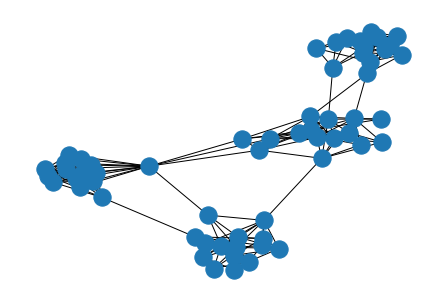

In [3]:
nx.draw(G_gn)

In [2]:
def Simu(G, infoG, dynamics_list = cf.dynamics_list, norm=True, t_scale = 1, t_max = 1):
    """
    Inputs: dynamics (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
    """
    print('-------- GRAPH DISTANCES --------')
    start_time = time.time()
    
    num_nodes = G.number_of_nodes()
    #num_time_points = 50 # small to decrease computational load
    times = np.linspace(0, num_nodes, num = num_nodes+1) #time to find the steady state    
    times_perturbation = np.linspace(0, int(num_nodes * t_max), num = int((num_nodes+1)*t_scale)) #times at which we look how the perturbation evolves
    
    if nx.is_connected(G) == 0:
        raise ValueError('The network should be in a single component. Exit!')
    
    dist_t = []
    avg_dist_t = []
    eigvals = []
    
    for dynamics in dynamics_list:
        
        if dynamics == 'Diffusion':
            ### DIFFUSION
            print('[*] DIFFUSION DISTANCE')
            print('Evaluating diffusion distance...')
            tmp_d = cf.Laplacian(nx.to_numpy_array(G), times_perturbation, return_snapshot=True, norm=True)
        
        else:
            ### JACOBIAN
            print('[*] JACOBIAN DISTANCE - '+str(dynamics))
        
            #Integration to get the steady state
            print('Integration up to steady state...')
            initial_state = np.random.random(len(G.nodes()))
            SteadyState_ref = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1)
            SteadyState_ref = SteadyState_ref[-1]

            # analytical expression of Jacobian
            print('Evaluating jacobian distance...')
            tmp_d = cf.Jacobian(G, dynamics, SteadyState_ref, times_perturbation, return_snapshot=True, norm=norm)
        
        dist_t.append(tmp_d[0])
        avg_dist_t.append(tmp_d[1])
        eigvals.append(tmp_d[2])
        
    return dist_t, avg_dist_t, eigvals, times_perturbation

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Mutualistic
Integration up to steady state...


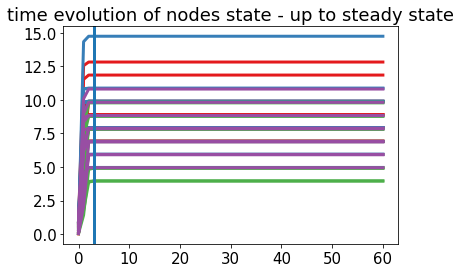

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Biochemical
Integration up to steady state...


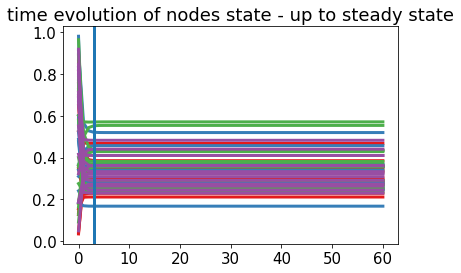

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Population
Integration up to steady state...


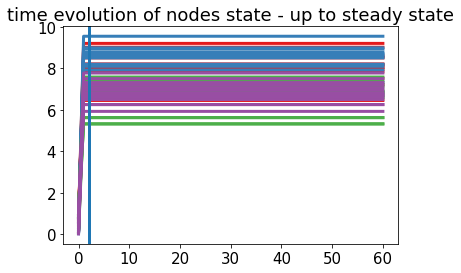

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Regulatory
Integration up to steady state...


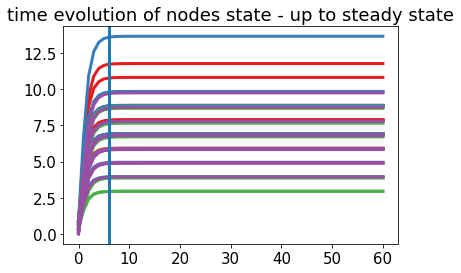

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Epidemics
Integration up to steady state...


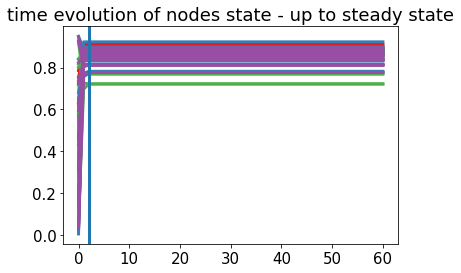

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Synchronization
Integration up to steady state...


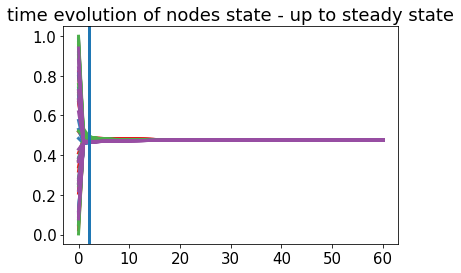

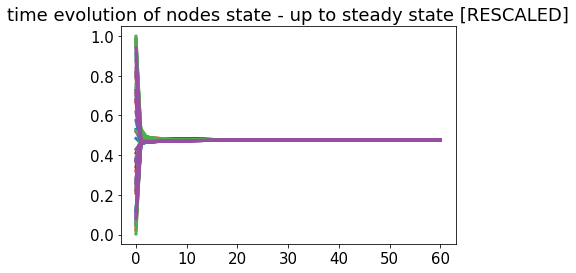

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Neuronal
Integration up to steady state...


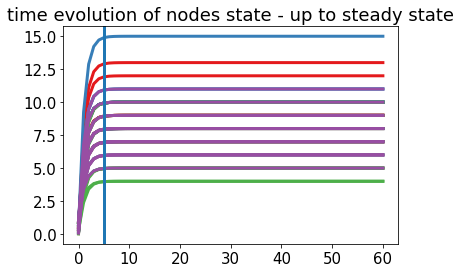

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - NoisyVM
Integration up to steady state...


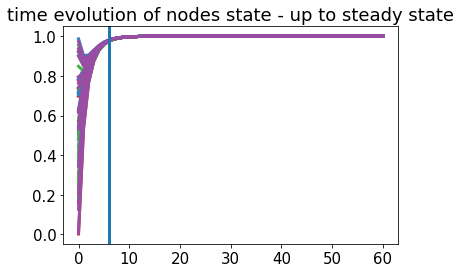

Evaluating jacobian distance...



[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


In [18]:
dist_t, avg_dist_t, eigvals, times = Simu(G_gn, infoG_gn, norm=False, t_scale = 5, t_max = 2)

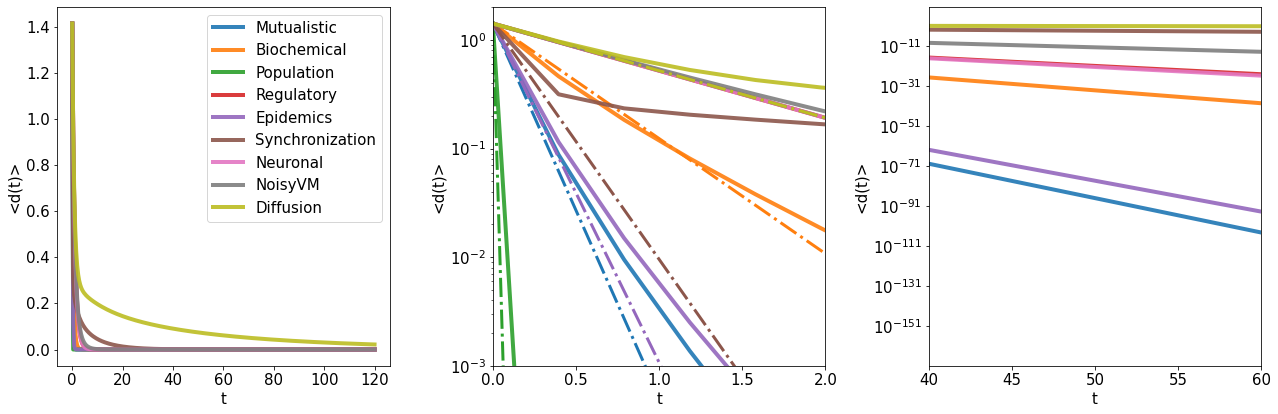

In [14]:
cmap = cm.get_cmap('tab10')

plt.figure(figsize=(18,6))

lw = 4.

plt.subplot(1,3,1)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9)

plt.xlabel('t')
plt.ylabel('<d(t)>')
#plt.yscale('log')
plt.legend()

plt.subplot(1,3,2)

tt = 10
tt = np.arange(0,tt)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9, c=cmap(i))
    #plt.plot(tt, res[kk]*np.exp(tt*eigvals[i][-1].real))
    plt.plot(np.sqrt(2)*np.exp(tt*eigvals[i][-1].real), '-.', c=cmap(i))
plt.ylim([1e-3, 2])
plt.xlim([0, 2])
plt.xlabel('t')
plt.ylabel('<d(t)>')
plt.yscale('log')
#plt.legend()

plt.subplot(1,3,3)

#tt = 30
#kk = 50
#tt = np.arange(kk,tt+kk)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9)
    #plt.plot(tt, res[kk]*np.exp(tt*eigvals[i][-1].real))
#plt.ylim([1e-5, 2])
plt.xlim([40, 60])
plt.xlabel('t')
plt.ylabel('<d(t)>')
plt.yscale('log')
#plt.legend()

plt.tight_layout()
plt.show()

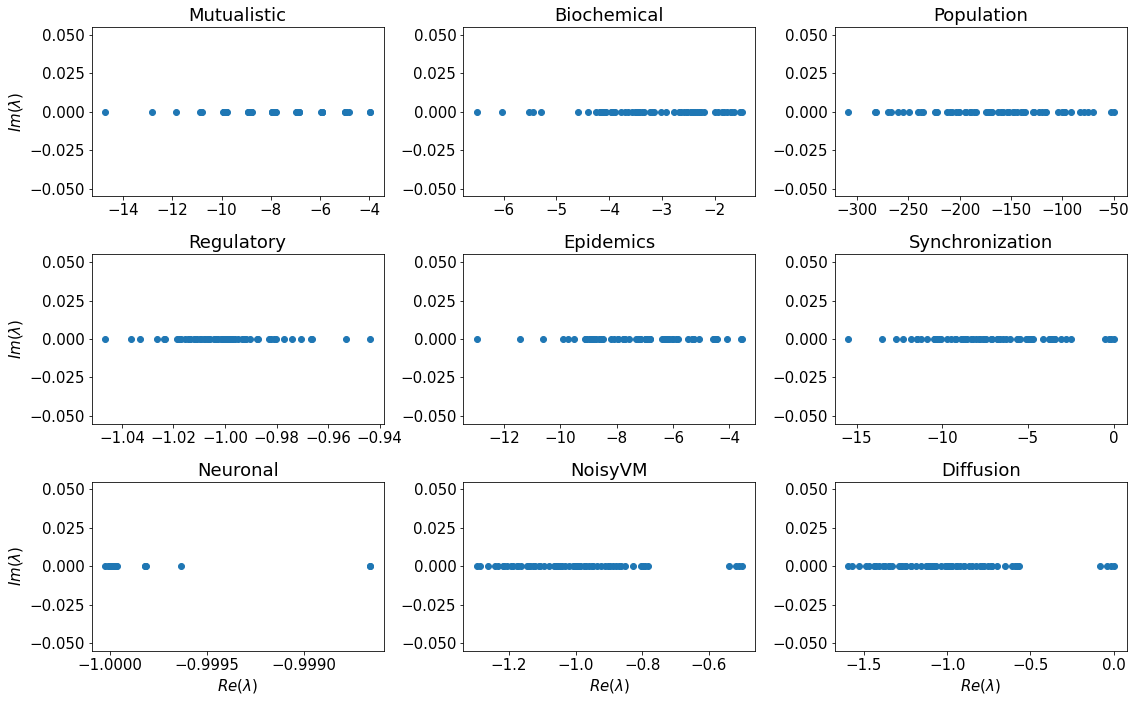

In [17]:
plt.figure(figsize=(16,10))

for i, eig in enumerate(eigvals):
    plt.subplot(3, 3, i+1)

    plt.scatter(eig.real, eig.imag)

    if i%3==0:
        plt.ylabel(r'$Im(\lambda)$')
    if i-5>0:
        plt.xlabel(r'$Re(\lambda)$')
    
    plt.title(cf.dynamics_list[i])

plt.tight_layout()
plt.show()

In [ ]:
dist_t, avg_dist_t, eigvals, times = Simu(G_gn, infoG_gn, norm=False, t_scale = 10, t_max = 0.1)

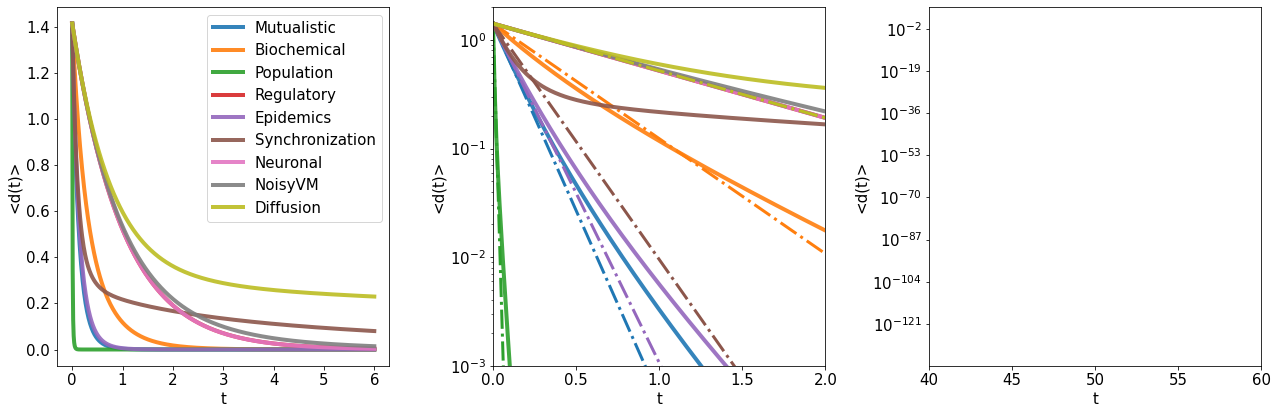

In [19]:
cmap = cm.get_cmap('tab10')

plt.figure(figsize=(18,6))

lw = 4.

plt.subplot(1,3,1)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9)

plt.xlabel('t')
plt.ylabel('<d(t)>')
#plt.yscale('log')
plt.legend()

plt.subplot(1,3,2)

tt = 10
tt = np.arange(0,tt)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9, c=cmap(i))
    #plt.plot(tt, res[kk]*np.exp(tt*eigvals[i][-1].real))
    plt.plot(np.sqrt(2)*np.exp(tt*eigvals[i][-1].real), '-.', c=cmap(i))
plt.ylim([1e-3, 2])
plt.xlim([0, 2])
plt.xlabel('t')
plt.ylabel('<d(t)>')
plt.yscale('log')
#plt.legend()

plt.subplot(1,3,3)

#tt = 30
#kk = 50
#tt = np.arange(kk,tt+kk)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9)
    #plt.plot(tt, res[kk]*np.exp(tt*eigvals[i][-1].real))
#plt.ylim([1e-5, 2])
plt.xlim([40, 60])
plt.xlabel('t')
plt.ylabel('<d(t)>')
plt.yscale('log')
#plt.legend()

plt.tight_layout()
plt.show()

In [20]:
for i, eig in enumerate(eigvals):
    print(cf.dynamics_list[i], np.max(eig.real), np.min(eig.real))

Mutualistic -3.9475343193306256 -12.86114805279665
Biochemical -1.5459012477195977 -6.174566090760823
Population -49.828906314107876 -317.59065900205167
Regulatory -0.9497724316751341 -1.0386390529896157
Epidemics -3.5193700386345377 -11.617816552113585
Synchronization -4.926614671774132e-16 -13.421037892310755
Neuronal -0.9986534028613481 -1.0000098298858622
NoisyVM -0.4999999999999991 -1.2965431967243226
Diffusion 1.593086393448655 2.42861286636753e-17


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


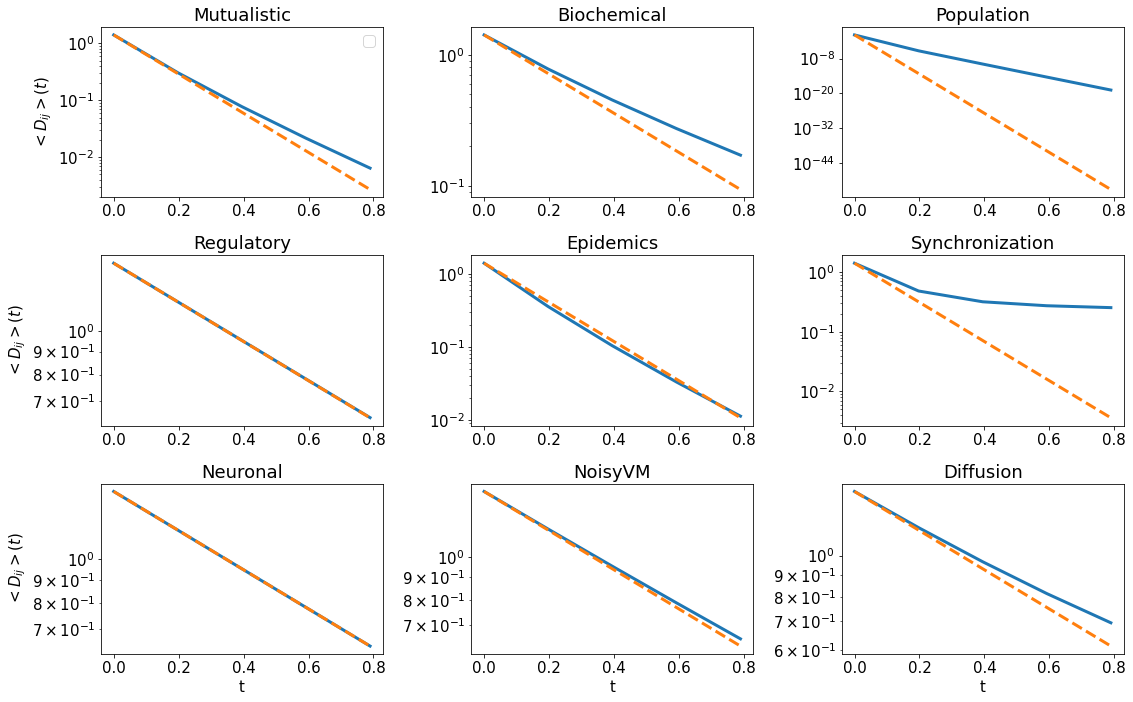

In [72]:
plt.figure(figsize=(16,10))

T = 5
tt = times[:T]

for i, res in enumerate(dist_t):
    plt.subplot(3, 3, i+1)

    plt.plot(tt, res[:T])
    plt.plot(tt, np.sqrt(2)*np.exp(tt*eigvals[i][-1].real), '--')

    plt.yscale('log')

    if i%3==0:
        plt.ylabel('$<D_{ij}>(t)$')
    if i-5>0:
        plt.xlabel('t')
    
    plt.title(cf.dynamics_list[i])
    
    if i==0:
        plt.legend()

plt.tight_layout()
plt.show()

# Normalize time wrt lambda max

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Mutualistic
Integration up to steady state...


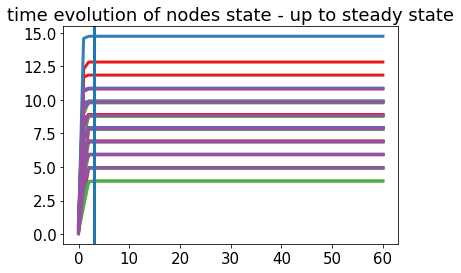

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Biochemical
Integration up to steady state...


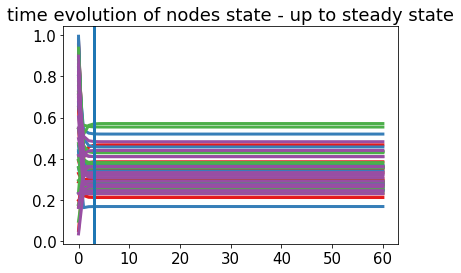

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Population
Integration up to steady state...


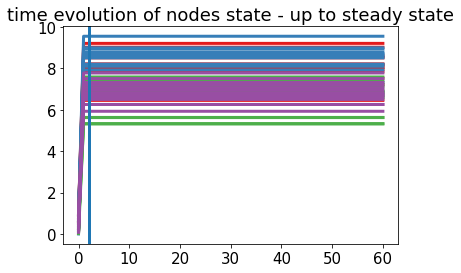

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Regulatory
Integration up to steady state...


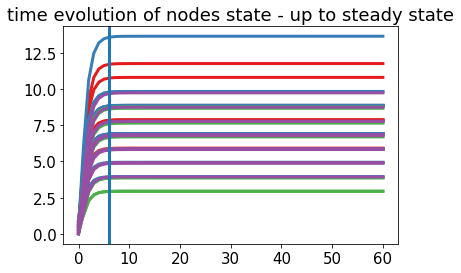

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Epidemics
Integration up to steady state...


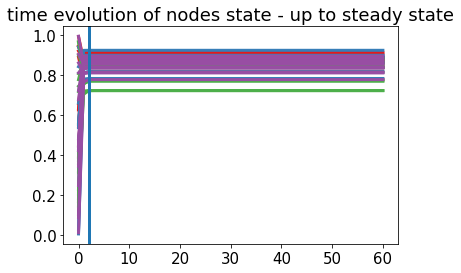

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Synchronization
Integration up to steady state...


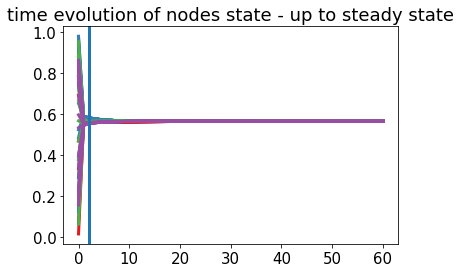

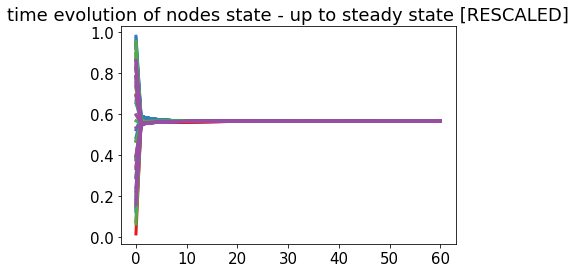

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - Neuronal
Integration up to steady state...


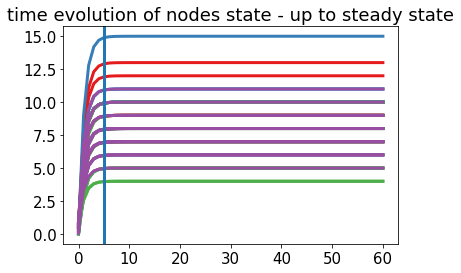

Evaluating jacobian distance...



[*] JACOBIAN DISTANCE - NoisyVM
Integration up to steady state...


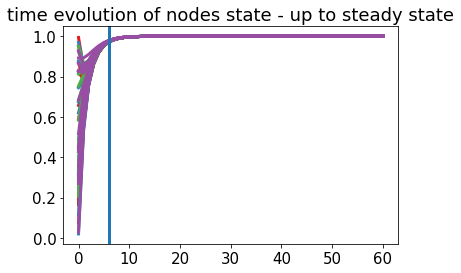

Evaluating jacobian distance...



[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


In [20]:
dist_t, avg_dist_t, eigvals, times = Simu(G_gn, infoG_gn, norm=True, t_scale = 5, t_max = 2)

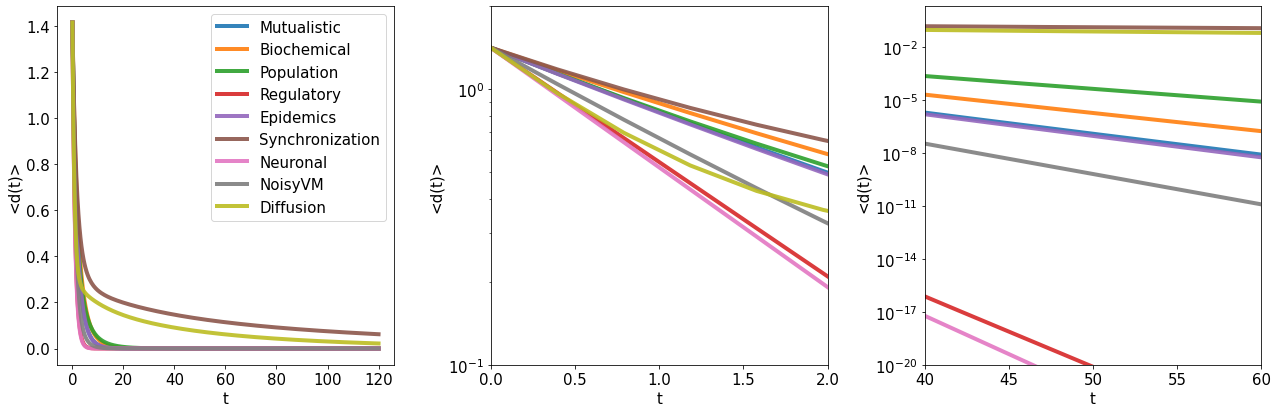

In [27]:
cmap = cm.get_cmap('tab10')

plt.figure(figsize=(18,6))

lw = 4.

plt.subplot(1,3,1)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9)

plt.xlabel('t')
plt.ylabel('<d(t)>')
#plt.yscale('log')
plt.legend()

plt.subplot(1,3,2)

tt = 10
tt = np.arange(0,tt)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9, c=cmap(i))
    #plt.plot(tt, res[kk]*np.exp(tt*eigvals[i][-1].real))
    #plt.plot(np.sqrt(2)*np.exp(tt*eigvals[i][-1].real), '-.', c=cmap(i))
plt.ylim([1e-1, 2])
plt.xlim([0, 2])
plt.xlabel('t')
plt.ylabel('<d(t)>')
plt.yscale('log')
#plt.legend()

plt.subplot(1,3,3)

#tt = 30
#kk = 50
#tt = np.arange(kk,tt+kk)

for i, res in enumerate(dist_t):
    plt.plot(times, res, label=cf.dynamics_list[i], lw=lw, alpha=0.9)
    #plt.plot(tt, res[kk]*np.exp(tt*eigvals[i][-1].real))
plt.ylim([1e-20, 2])
plt.xlim([40, 60])
plt.xlabel('t')
plt.ylabel('<d(t)>')
plt.yscale('log')
#plt.legend()

plt.tight_layout()
plt.show()

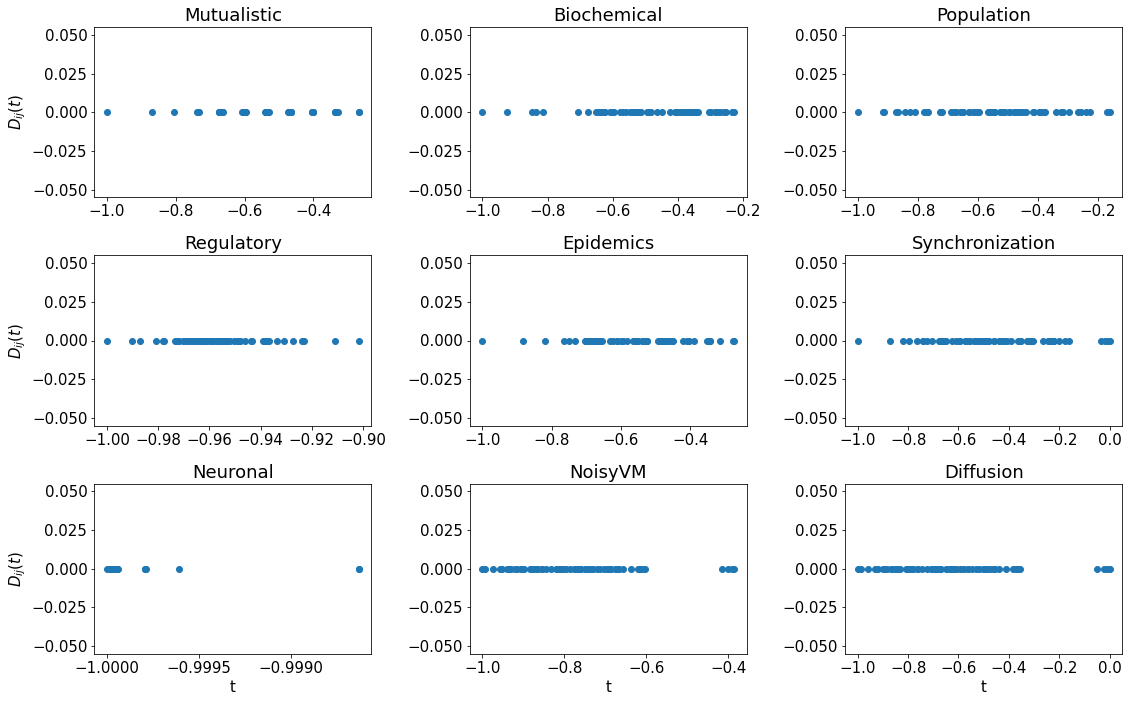

In [ ]:
plt.figure(figsize=(16,10))

for i, eig in enumerate(eigvals):
    plt.subplot(3, 3, i+1)

    plt.scatter(-eig.real/np.min(eig.real), eig.imag)

    if i%3==0:
        plt.ylabel(r'$D_{ij}(t)$')
    if i-5>0:
        plt.xlabel('t')
    
    plt.title(cf.dynamics_list[i])

plt.tight_layout()
plt.show()

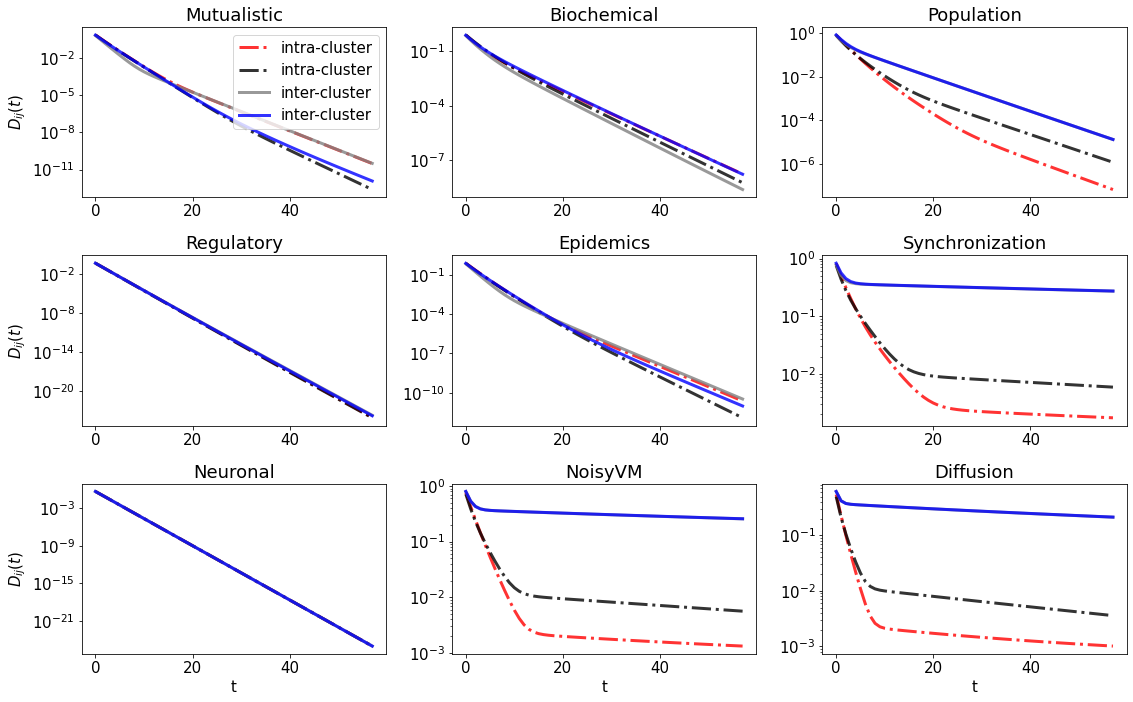

In [106]:
node_a = 0
node_b = 1
node_c = N-2
node_d = N-1

Tmax = N-1
alpha = 0.8

plt.figure(figsize=(16,10))

for i, res in enumerate(avg_dist_t):
    plt.subplot(3, 3, i+1)

    plt.plot(res[1:Tmax,node_a,node_b], '-.', label='intra-cluster', c='red', alpha=alpha)
    plt.plot(res[1:Tmax,node_c,node_d], '-.', label='intra-cluster', c='black', alpha=alpha)
    plt.plot(res[1:Tmax,node_a,node_c], label='inter-cluster', c='gray', alpha=alpha)
    plt.plot(res[1:Tmax,node_b,node_c], label='inter-cluster', c='blue', alpha=alpha)

    plt.yscale('log')

    if i%3==0:
        plt.ylabel(r'$D_{ij}(t)$')
    if i-5>0:
        plt.xlabel('t')
    
    plt.title(cf.dynamics_list[i])
    
    if i==0:
        plt.legend()

plt.tight_layout()
plt.show()

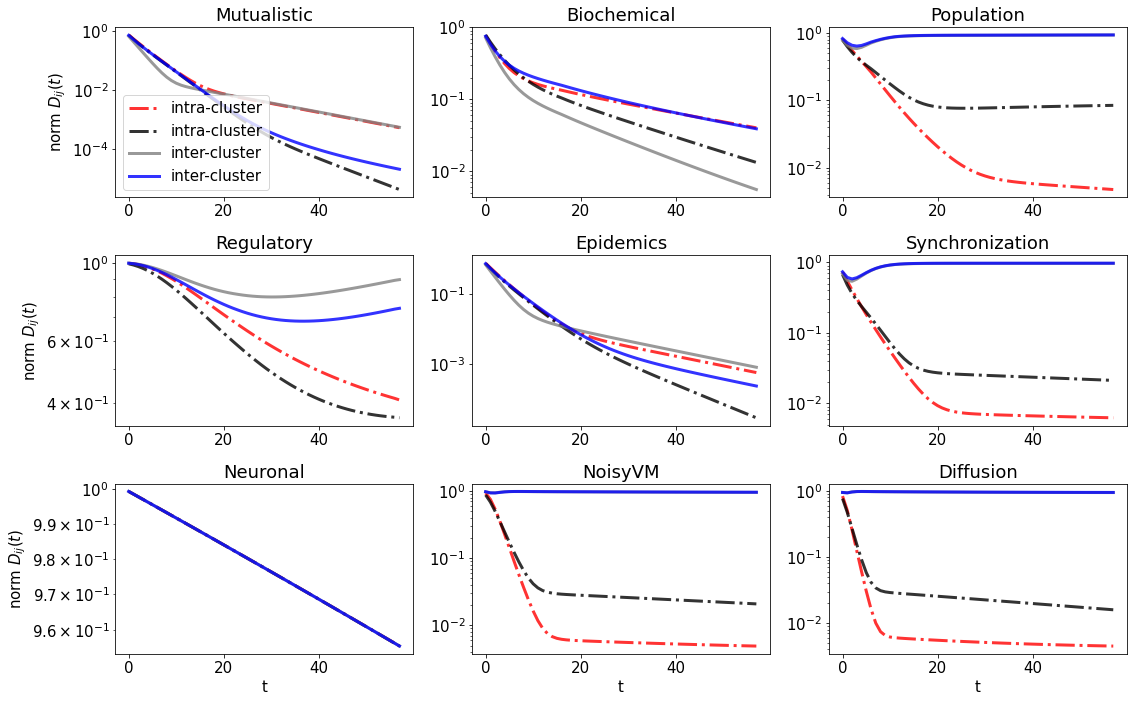

In [101]:
node_a = 0
node_b = 1
node_c = N-2
node_d = N-1

Tmax = N-1
alpha = 0.8

plt.figure(figsize=(16,10))

for i, res in enumerate(avg_dist_t):
    plt.subplot(3, 3, i+1)

    plt.plot(res[1:Tmax,node_a,node_b] / np.max(res[1:Tmax],axis=2).max(axis=1), '-.', label='intra-cluster', c='red', alpha=alpha)
    plt.plot(res[1:Tmax,node_c,node_d] / np.max(res[1:Tmax],axis=2).max(axis=1), '-.', label='intra-cluster', c='black', alpha=alpha)
    plt.plot(res[1:Tmax,node_a,node_c] / np.max(res[1:Tmax],axis=2).max(axis=1), label='inter-cluster', c='gray', alpha=alpha)
    plt.plot(res[1:Tmax,node_b,node_c] / np.max(res[1:Tmax],axis=2).max(axis=1), label='inter-cluster', c='blue', alpha=alpha)

    plt.yscale('log')

    if i%3==0:
        plt.ylabel(r'norm $D_{ij}(t)$')
    if i-5>0:
        plt.xlabel('t')
    
    plt.title(cf.dynamics_list[i])
    
    if i==0:
        plt.legend()

plt.tight_layout()
plt.show()

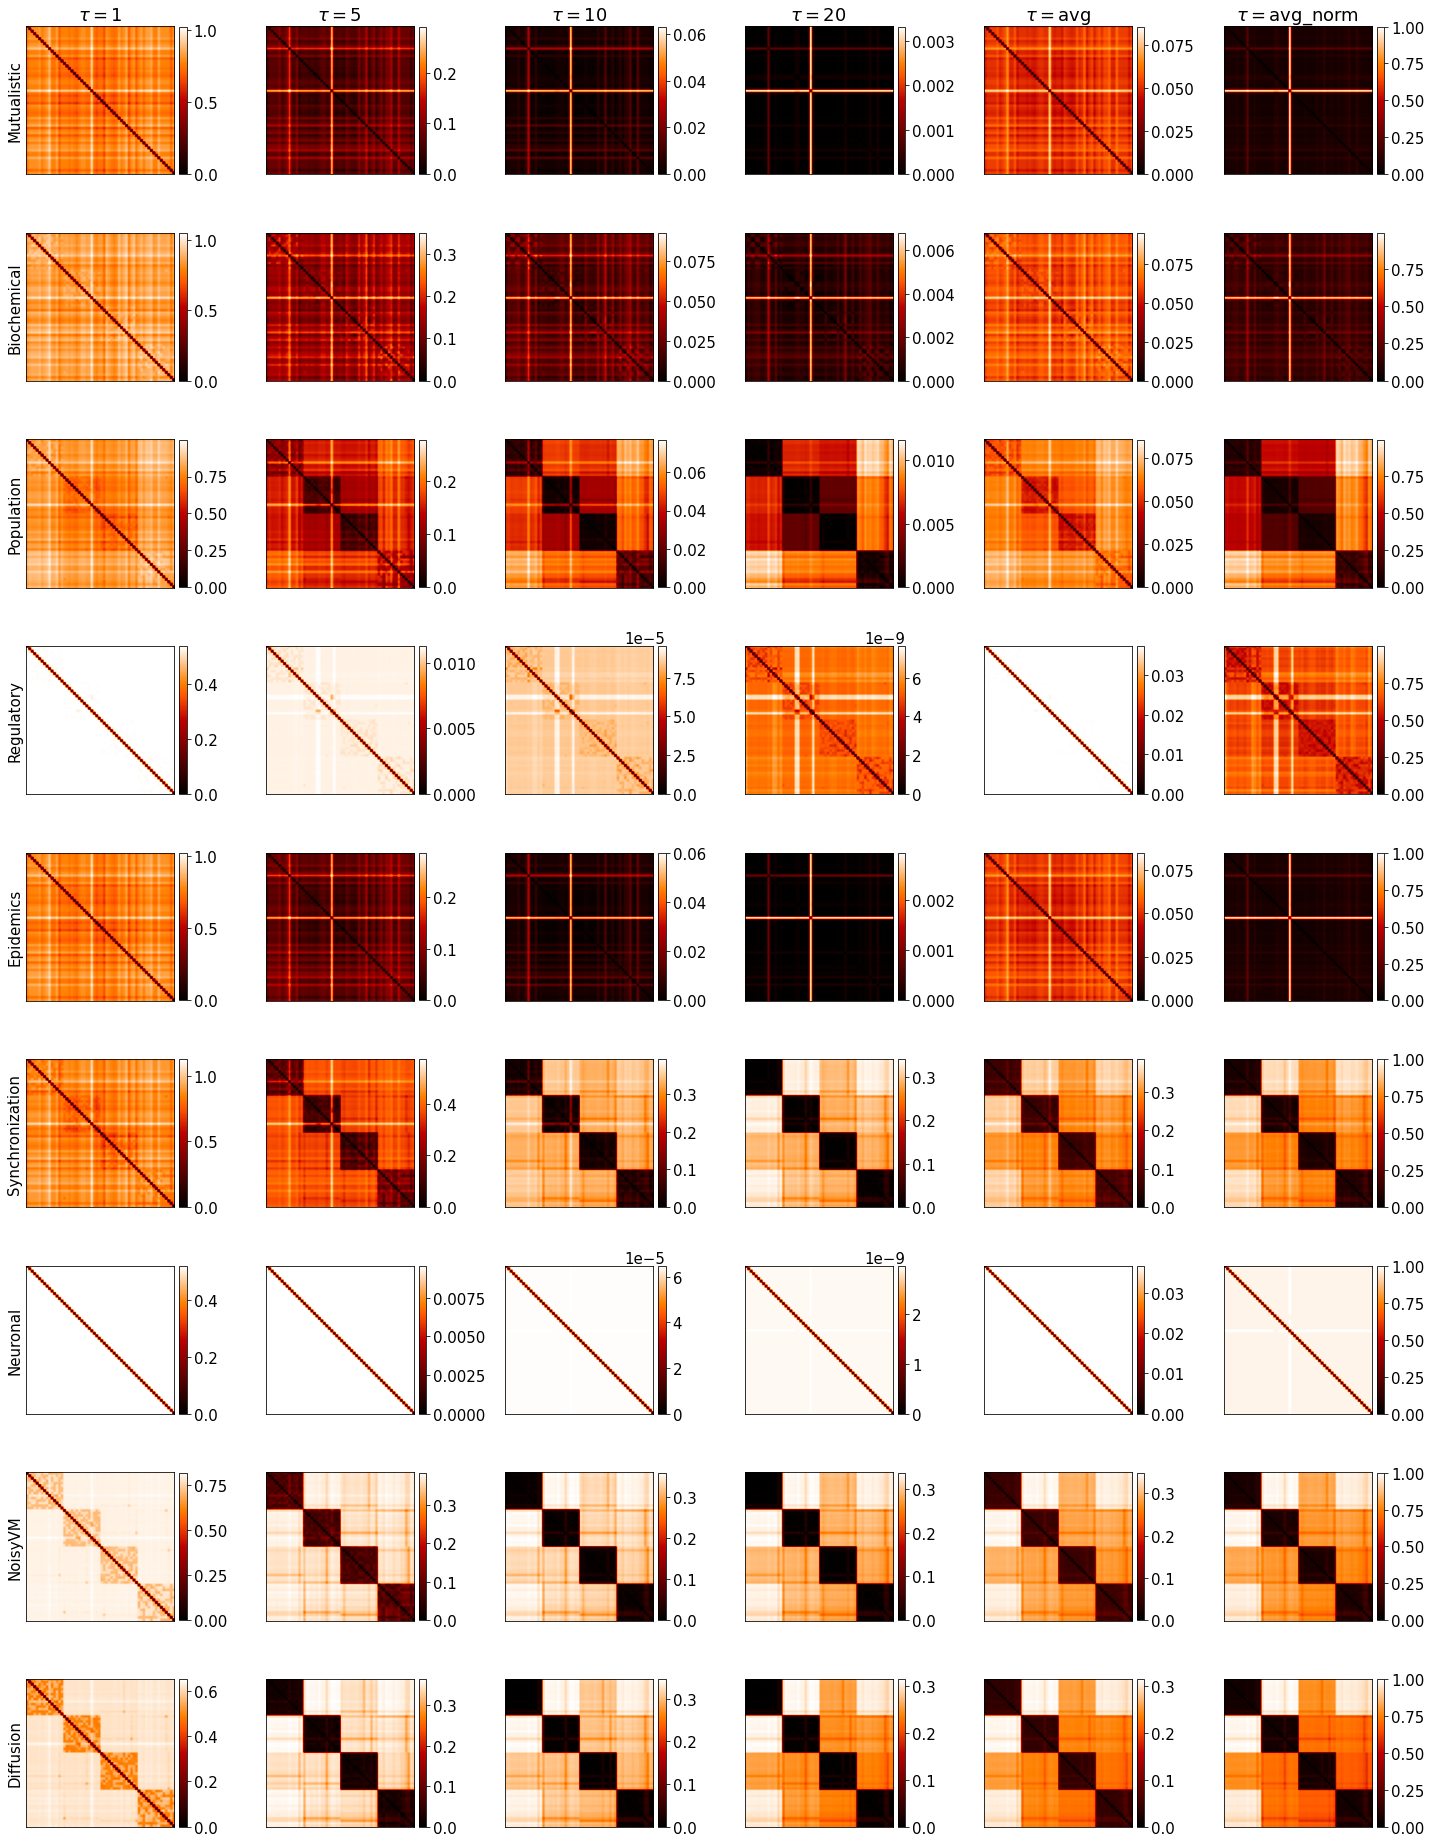

In [90]:
plotter.plot_dist_matrix_evol(avg_dist_t, cf.dynamics_list, hspace=-0.7)

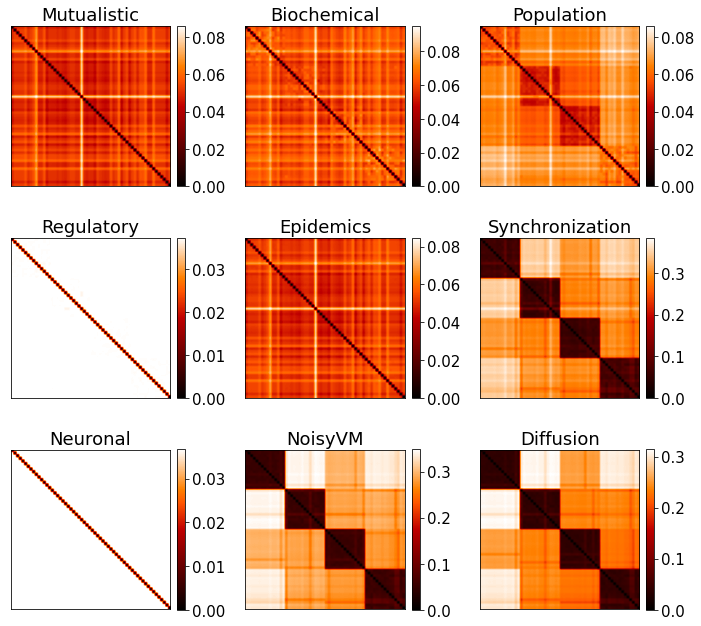

In [78]:
plotter.plot_average_dist_matrix(avg_dist_t, cf.dynamics_list, hspace=-.95)

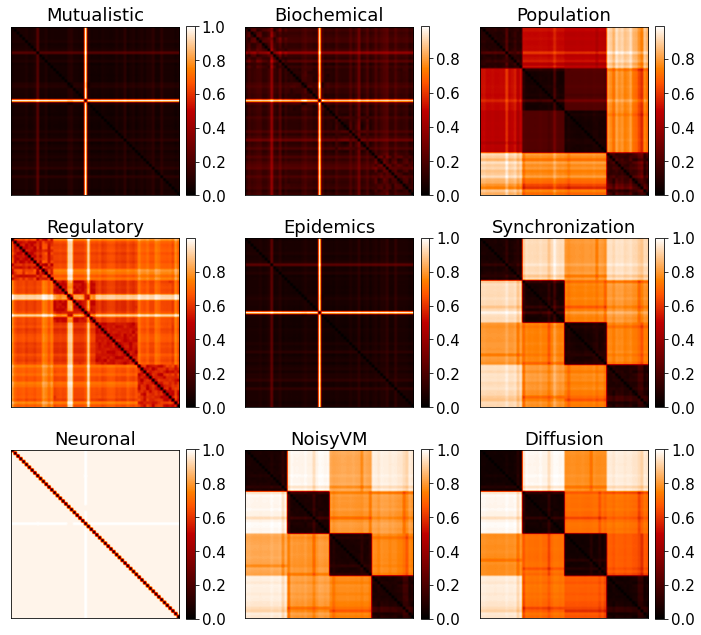

In [79]:
plotter.plot_average_dist_matrix(avg_dist_t, cf.dynamics_list, hspace=-.95, norm = True)

In [88]:
# Get metadata from graph
metadata = dict(G_gn.nodes(data=True))
blocks = [metadata[tmp]['block'] for tmp in metadata]
blocks = np.array(blocks)

# Define block colors
lut = dict(zip(np.unique(blocks), "rbgy"))
row_colors = [lut[element] for element in blocks]

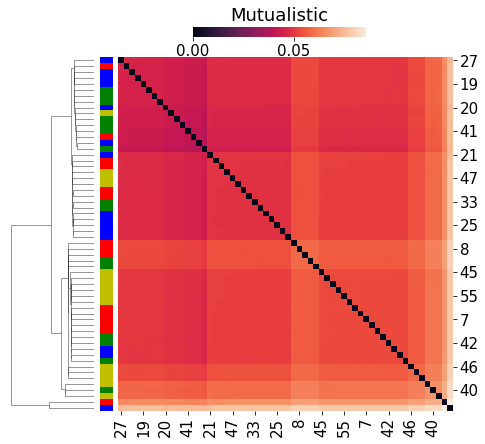

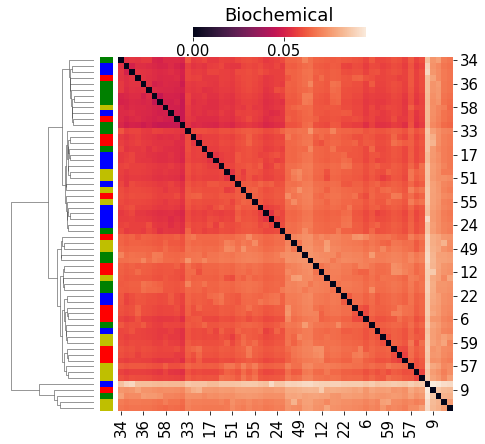

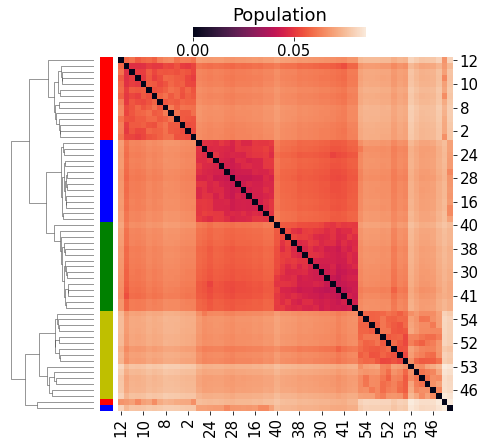

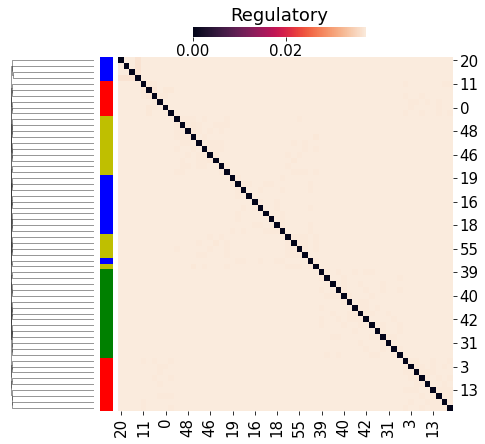

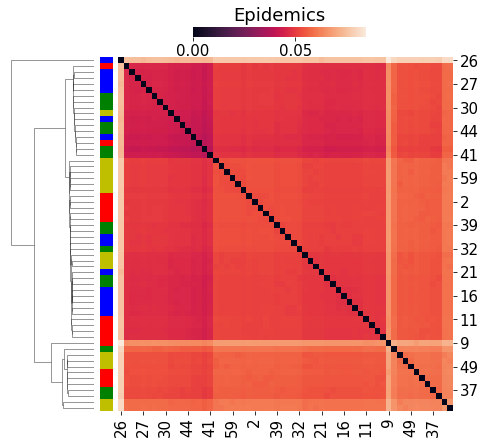

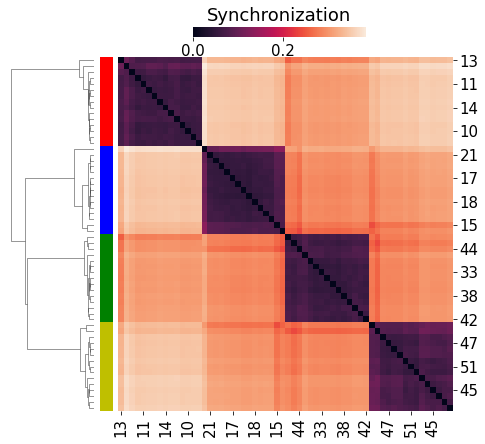

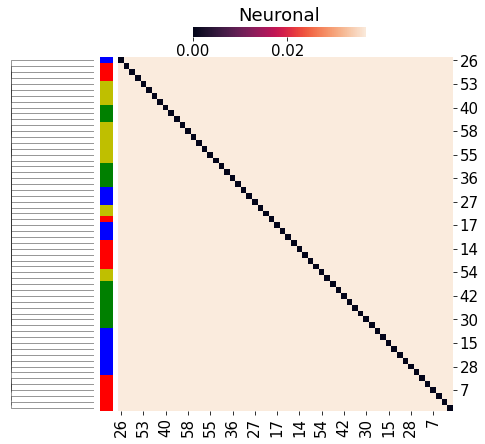

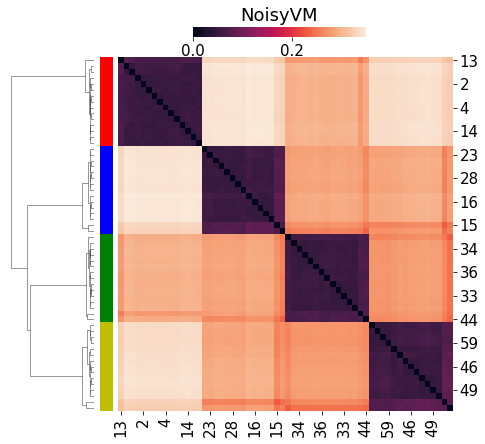

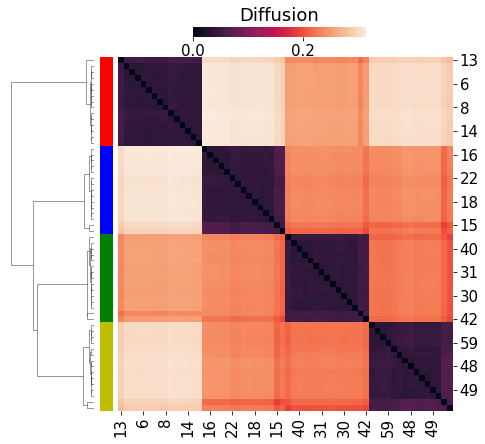

In [129]:
# Get average distance matrices
avg_dist_mats = [cf.get_average_distance_matrix(mat, norm=False) for mat in avg_dist_t]

for i, matrix in enumerate(avg_dist_mats):
    plotter.plot_clustermap(matrix, row_colors=row_colors, figsize=(7,7), title=cf.dynamics_list[i], save=True, dpi=500)

In [110]:
import matplotlib.image as mpimg

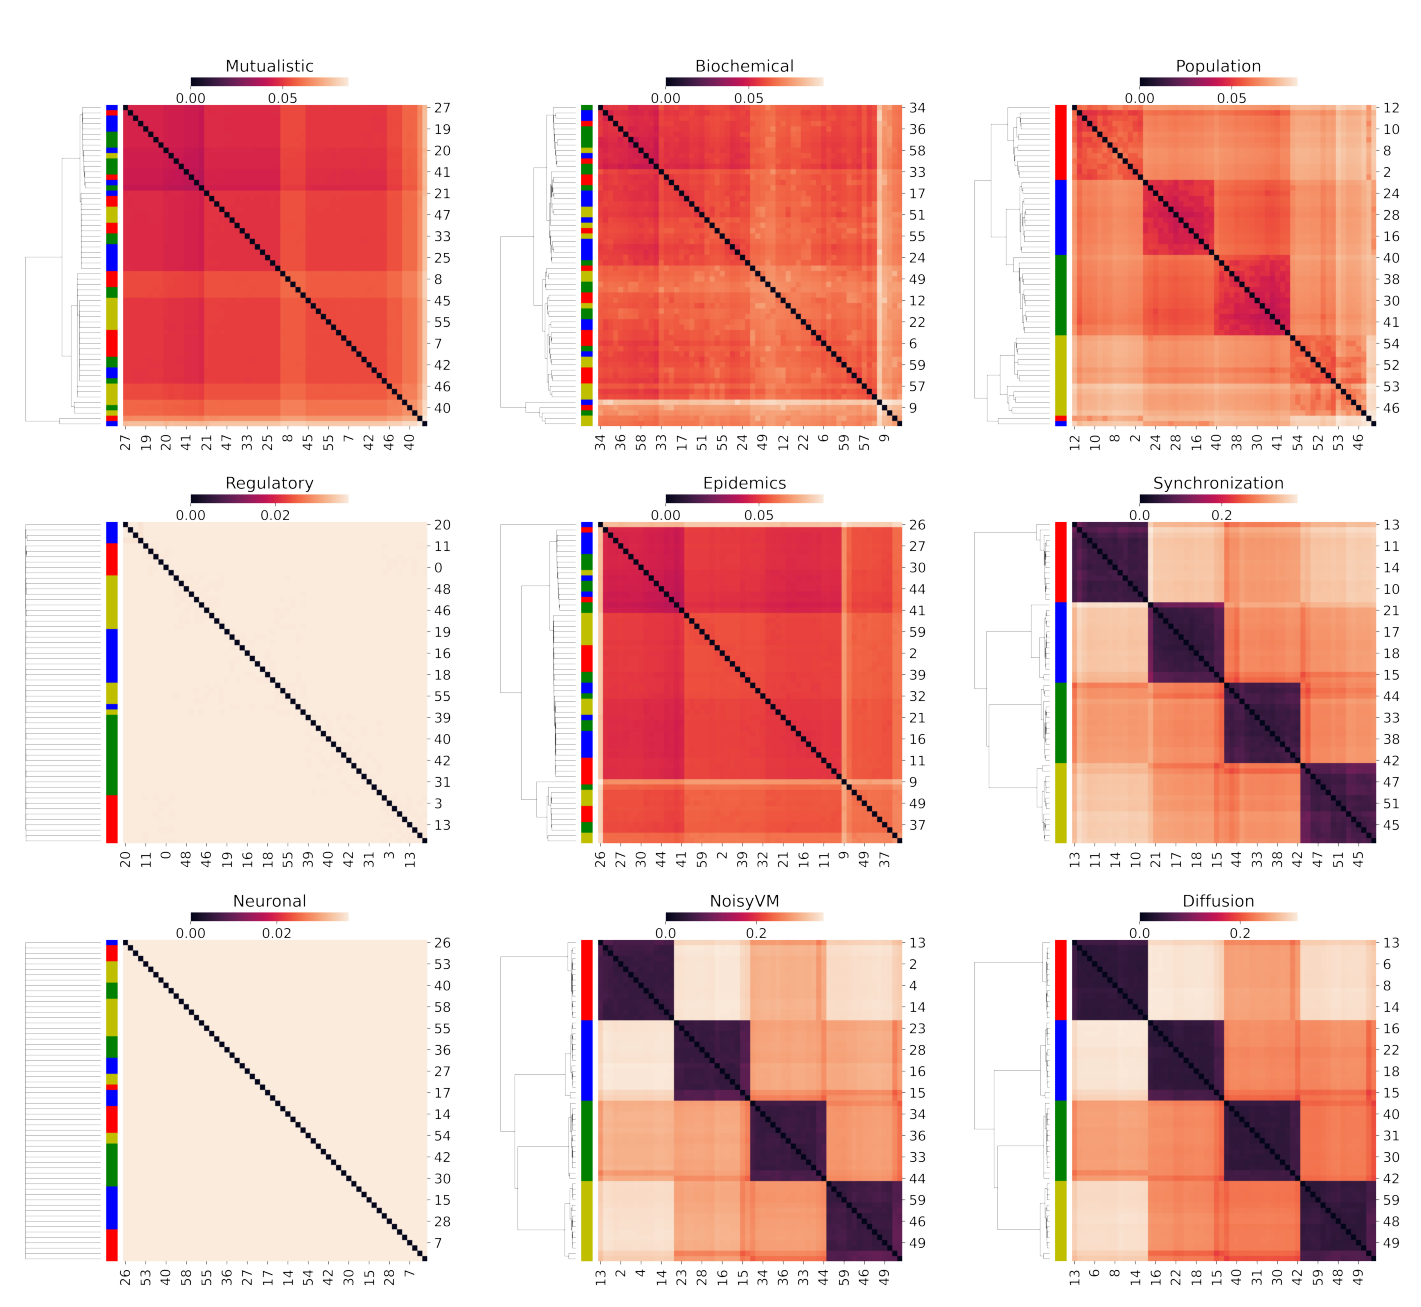

In [132]:
plt.figure(figsize=(20,20))

for i, dynamic in enumerate(cf.dynamics_list):
    plt.subplot(3,3,i+1)
    
    img = mpimg.imread(dynamic+'.png')
    plt.imshow(img)
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=-0.5)
plt.tight_layout()
plt.show()

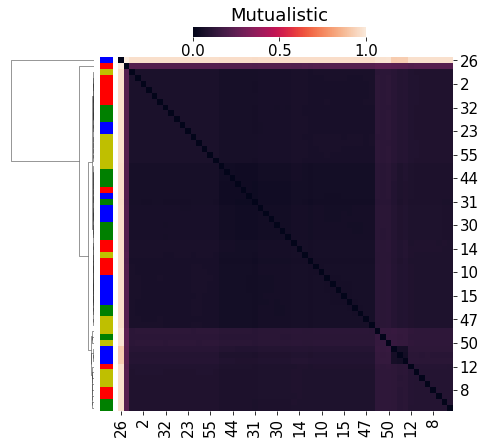

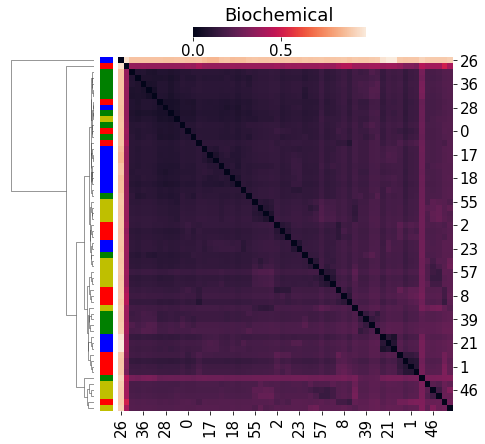

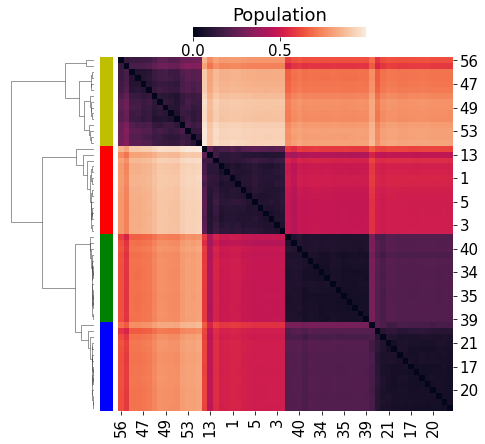

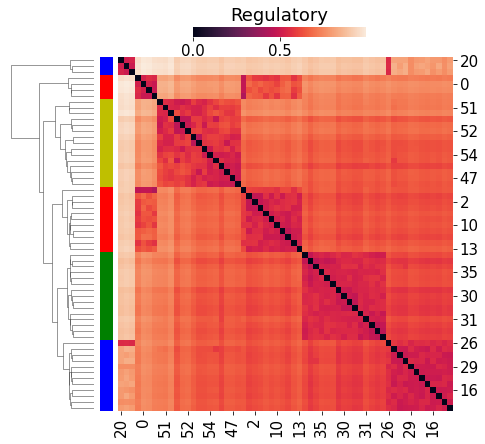

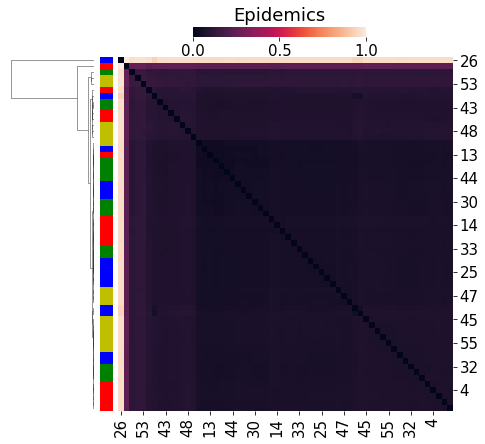

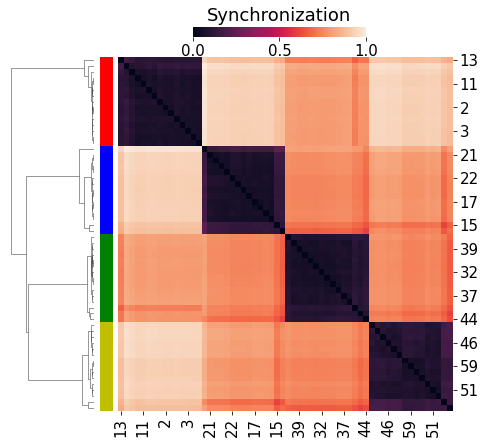

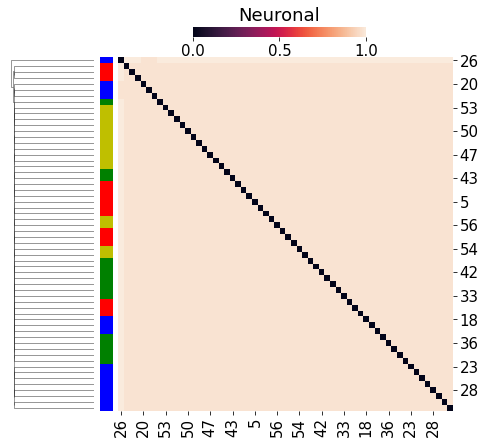

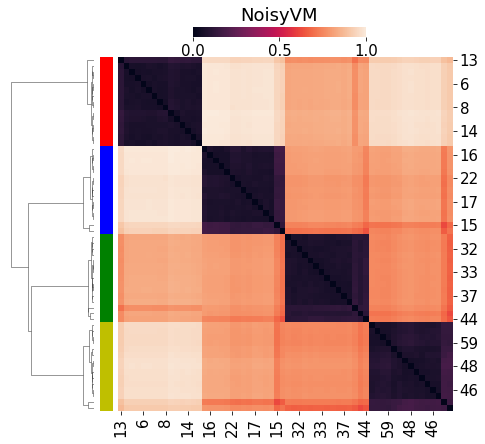

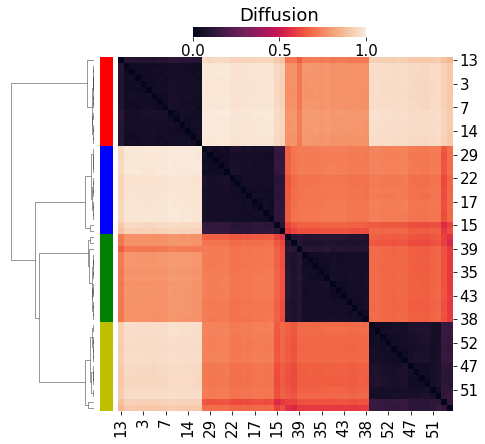

In [133]:
# Get average distance matrices
avg_dist_mats = [cf.get_average_distance_matrix(mat, norm=True) for mat in avg_dist_t]

for i, matrix in enumerate(avg_dist_mats):
    plotter.plot_clustermap(matrix, row_colors=row_colors, figsize=(7,7), title=cf.dynamics_list[i], save=True, dpi=500)

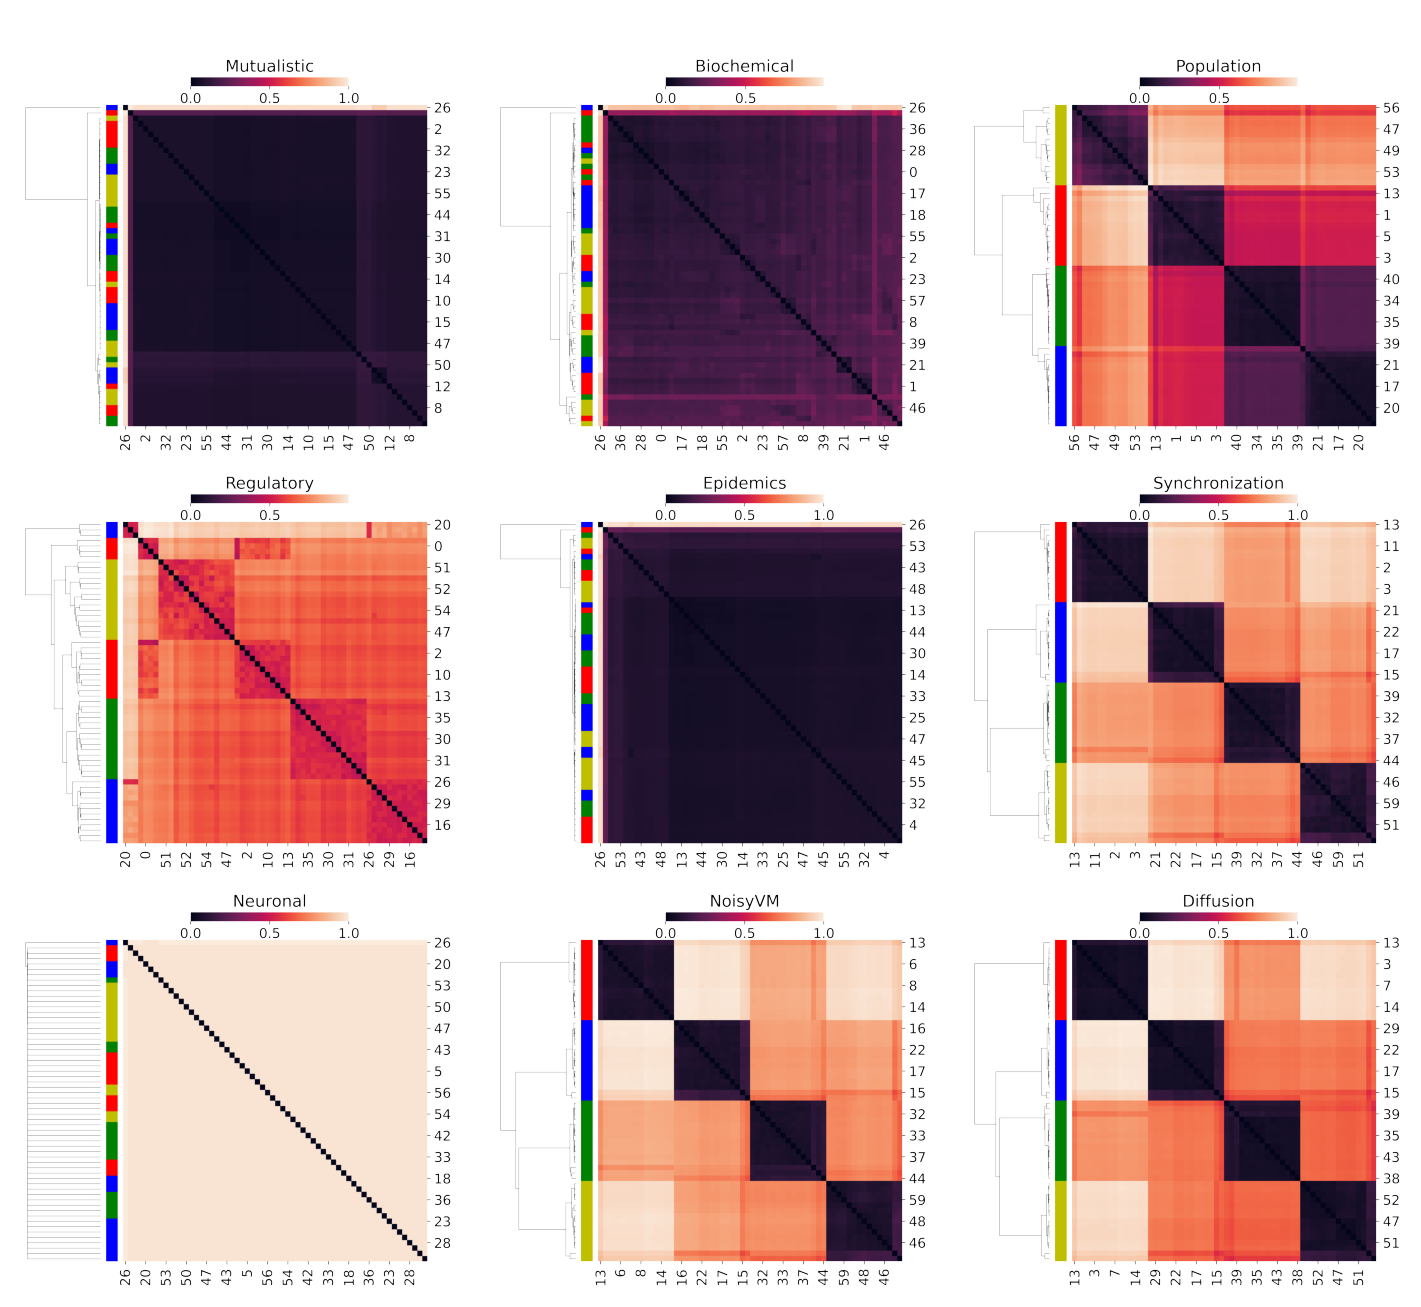

In [134]:
plt.figure(figsize=(20,20))

for i, dynamic in enumerate(cf.dynamics_list):
    plt.subplot(3,3,i+1)
    
    img = mpimg.imread(dynamic+'.png')
    plt.imshow(img)
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=-0.5)
plt.tight_layout()
plt.show()

# Mantel's test
https://github.com/jwcarr/mantel

In [137]:
import mantel
from matplotlib import cm
import copy

In [149]:
avg_dist_mats = [cf.get_average_distance_matrix(mat, norm=False) for mat in avg_dist_t]

corrs = np.zeros((len(cf.dynamics_list),len(cf.dynamics_list)))
pvalue = np.zeros((len(cf.dynamics_list),len(cf.dynamics_list)))

for i, matX in enumerate(avg_dist_mats[:-1]):
    for j, matY in enumerate(avg_dist_mats[i+1:]):
        tmp = mantel.test(matX, matY, perms=10000, method='pearson', tail='upper')
        print(cf.dynamics_list[i], cf.dynamics_list[i+j+1], tmp)
        corrs[i,i+j+1] = tmp[0]
        pvalue[i,i+j+1] = tmp[1]

Mutualistic Biochemical (0.9530574563500053, 0.0001, 7.464595181993204)
Mutualistic Population (0.5948509561856463, 0.0001, 5.852028911014299)
Mutualistic Regulatory (-0.09834248379997904, 0.9998, -3.4864302407347965)
Mutualistic Epidemics (0.9982498320359352, 0.0001, 7.703163674441077)
Mutualistic Synchronization (0.10935414526072075, 0.0001, 4.907426394879277)
Mutualistic Neuronal (0.7011381875321859, 0.0001, 5.4849509575859505)
Mutualistic NoisyVM (0.04227762738333455, 0.0184, 2.170079971143694)
Mutualistic Diffusion (0.04444126943184181, 0.0552, 1.6742209011746203)
Biochemical Population (0.4705747593904729, 0.0001, 4.815914556381809)
Biochemical Regulatory (-0.24394482382450983, 1.0, -8.780922665666543)
Biochemical Epidemics (0.9413589067029573, 0.0001, 7.416467270181869)
Biochemical Synchronization (0.036934226972885356, 0.0582, 1.640001655873183)
Biochemical Neuronal (0.5890293965754858, 0.0001, 4.727701434991934)
Biochemical NoisyVM (-0.025620656971077578, 0.908, -1.30048192212

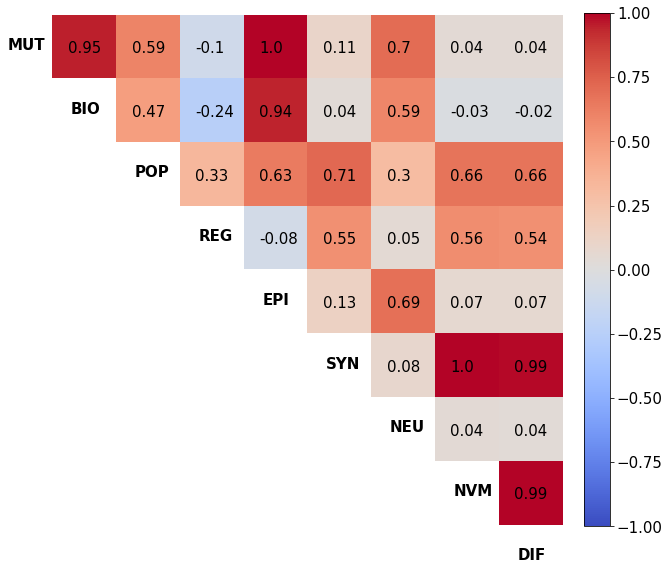

In [158]:
fig = plt.figure(figsize=(10,10))

corrs_mask = corrs[:-1]
corrs_mask = corrs_mask[:,1:]

corrs_mask[corrs_mask==0] = np.nan

cmap = cmap = copy.copy(cm.get_cmap("coolwarm"))
cmap.set_bad('w') # default value is 'k'

im = plt.imshow(corrs_mask, interpolation="nearest", cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.axis('off')

for i, name in enumerate(cf.dynamics_short):
    plt.text(i-1.2, i+0.05, name, weight="bold")
    
for i in range(corrs_mask.shape[0]):
    for j in range(i, corrs_mask.shape[0]):
        plt.text(j-0.25, i+0.1, corrs_mask[i,j].round(decimals=2))

plt.show()

In [159]:
avg_dist_mats = [cf.get_average_distance_matrix(mat, norm=True) for mat in avg_dist_t]

corrs = np.zeros((len(cf.dynamics_list),len(cf.dynamics_list)))
pvalue = np.zeros((len(cf.dynamics_list),len(cf.dynamics_list)))

for i, matX in enumerate(avg_dist_mats[:-1]):
    for j, matY in enumerate(avg_dist_mats[i+1:]):
        tmp = mantel.test(matX, matY, perms=10000, method='pearson', tail='upper')
        print(cf.dynamics_list[i], cf.dynamics_list[i+j+1], tmp)
        corrs[i,i+j+1] = tmp[0]
        pvalue[i,i+j+1] = tmp[1]

Mutualistic Biochemical (0.9647711811268918, 0.0001, 7.16829439121696)
Mutualistic Population (0.026254450142085793, 0.3162, 0.3799256642150306)
Mutualistic Regulatory (-0.013440318079869633, 0.349, -0.14237868913880428)
Mutualistic Epidemics (0.9988833913302981, 0.0001, 7.597743999608795)
Mutualistic Synchronization (0.052029624717490536, 0.0017, 2.454349332708198)
Mutualistic Neuronal (0.9709698025367366, 0.0001, 7.517279974164616)
Mutualistic NoisyVM (0.02213804869639153, 0.2198, 1.0721673740309812)
Mutualistic Diffusion (0.0212043836036459, 0.2498, 0.7361144889317905)
Biochemical Population (0.06195185914475082, 0.2171, 0.9046613590346667)
Biochemical Regulatory (-0.02356582619858124, 0.474, -0.23837658090911984)
Biochemical Epidemics (0.9668687974258081, 0.0001, 7.722658093684171)
Biochemical Synchronization (0.059998499164343425, 0.0005, 2.812960403921388)
Biochemical Neuronal (0.9090243285104188, 0.0001, 7.321373162859928)
Biochemical NoisyVM (0.026608622826138684, 0.1191, 1.289

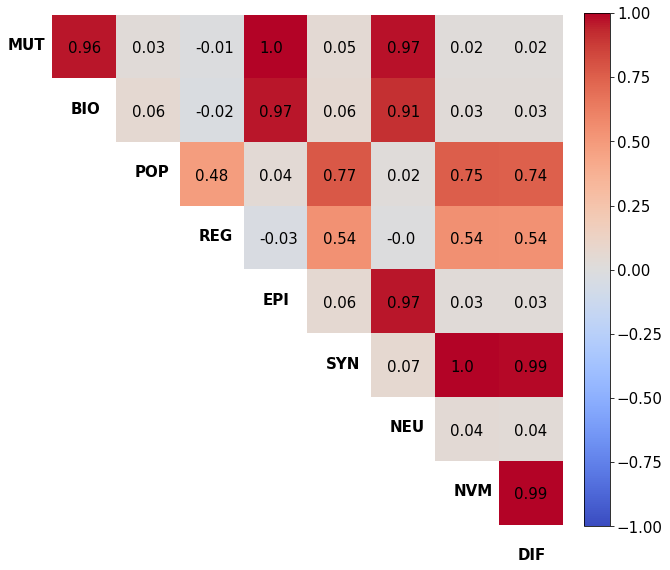

In [160]:
fig = plt.figure(figsize=(10,10))

corrs_mask = corrs[:-1]
corrs_mask = corrs_mask[:,1:]

corrs_mask[corrs_mask==0] = np.nan

cmap = cmap = copy.copy(cm.get_cmap("coolwarm"))
cmap.set_bad('w') # default value is 'k'

im = plt.imshow(corrs_mask, interpolation="nearest", cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.axis('off')

for i, name in enumerate(cf.dynamics_short):
    plt.text(i-1.2, i+0.05, name, weight="bold")
    
for i in range(corrs_mask.shape[0]):
    for j in range(i, corrs_mask.shape[0]):
        plt.text(j-0.25, i+0.1, corrs_mask[i,j].round(decimals=2))

plt.show()

# Try other topologies
- Barabasi-Albert scale-free
- Watts-Strogatz small-world
- Erdos-Renyi

### Generate networks...

In [12]:
N = 60
mean_deg = 8

G_ba = nx.barabasi_albert_graph(N, mean_deg)

while nx.is_connected(G_ba) == 0:
    print('The network should be in a single component. New trial!')
    G_ba = nx.barabasi_albert_graph(N, mean_deg)

print('Mean degree', np.mean(list(dict(G_ba.degree()).values())))

Mean degree 13.866666666666667


In [14]:
N = 60

G_ba = nx.barabasi_albert_graph(N, 4)

while nx.is_connected(G_ba) == 0:
    print('The network should be in a single component. New trial!')
    G_ba = nx.barabasi_albert_graph(N, 4)

print('Mean degree', np.mean(list(dict(G_ba.degree()).values())))

Mean degree 7.466666666666667


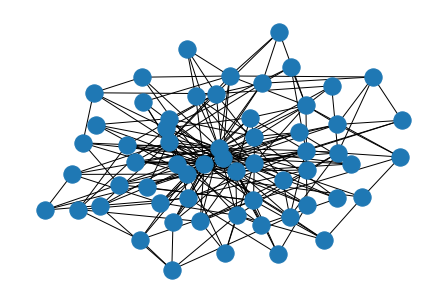

In [201]:
nx.draw(G_ba)

In [15]:
G_sw = nx.watts_strogatz_graph(N, k=mean_deg, p=0.2)
print('Mean degree', np.mean(list(dict(G_sw.degree()).values())))

Mean degree 8.0


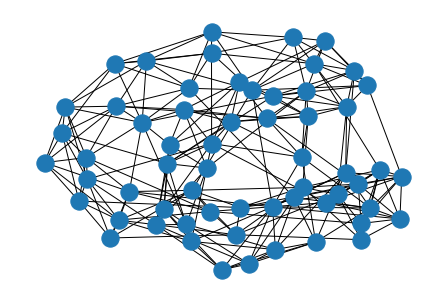

In [203]:
nx.draw(G_sw)

In [16]:
G_er = nx.fast_gnp_random_graph(N, p=mean_deg/N)
print('Mean degree', np.mean(list(dict(G_er.degree()).values())))

Mean degree 7.466666666666667


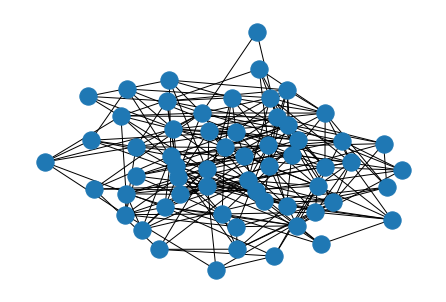

In [213]:
nx.draw(G_er)

### Compute Jacobian distances...

In [17]:
dynamics_list = ['Mutualistic', 'Biochemical', 'Population','Epidemics','Synchronization', 'Diffusion']

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Mutualistic
Integration up to steady state...


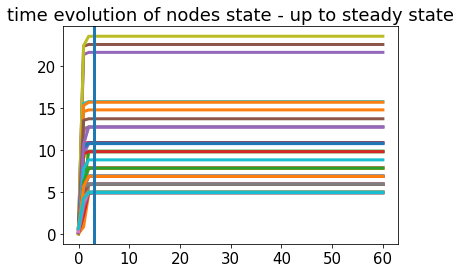

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Biochemical
Integration up to steady state...


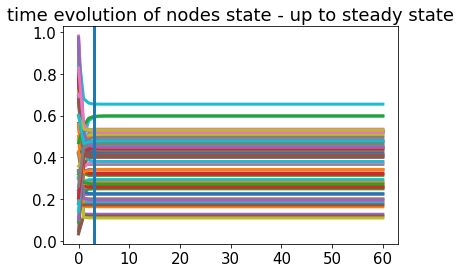

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Population
Integration up to steady state...


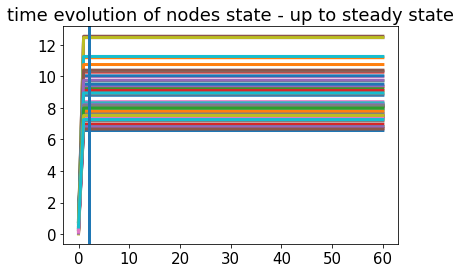

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Epidemics
Integration up to steady state...


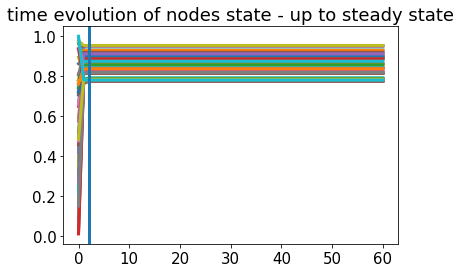

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Synchronization
Integration up to steady state...


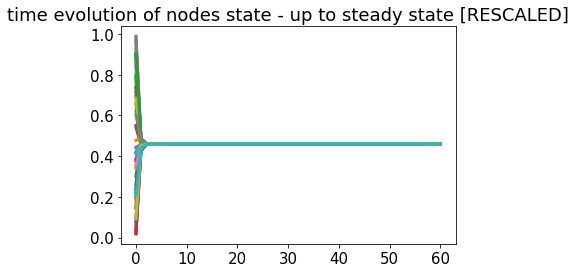

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


  0%|          | 0/61 [00:00<?, ?it/s]

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Mutualistic
Integration up to steady state...


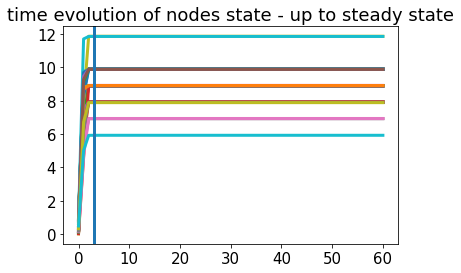

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Biochemical
Integration up to steady state...


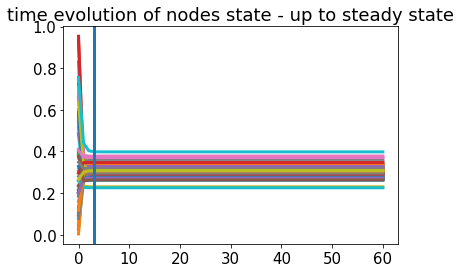

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Population
Integration up to steady state...


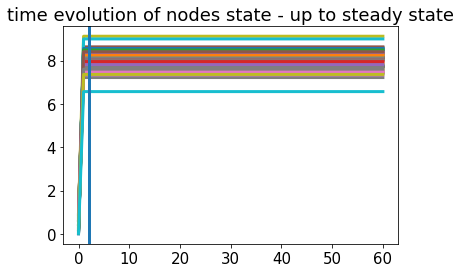

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Epidemics
Integration up to steady state...


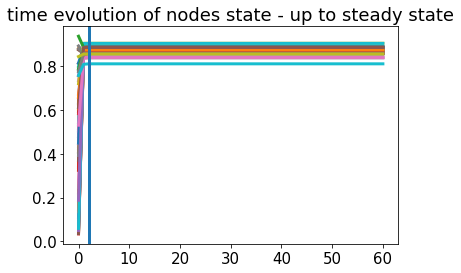

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Synchronization
Integration up to steady state...


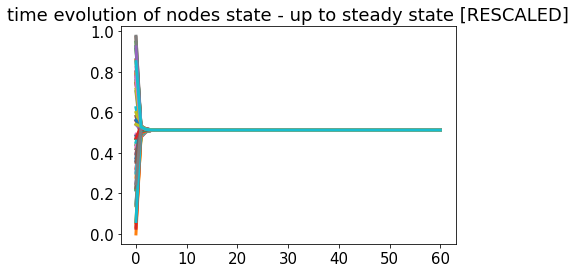

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


  0%|          | 0/61 [00:00<?, ?it/s]

-------- GRAPH DISTANCES --------
[*] JACOBIAN DISTANCE - Mutualistic
Integration up to steady state...


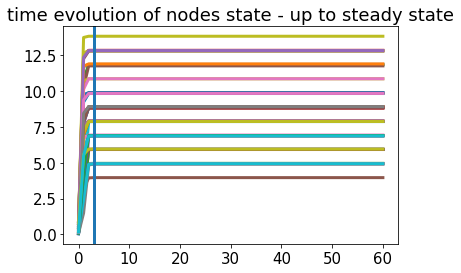

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Biochemical
Integration up to steady state...


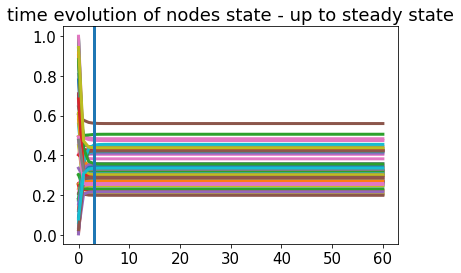

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Population
Integration up to steady state...


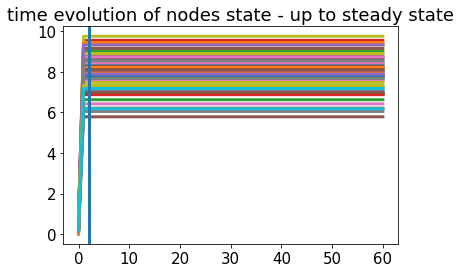

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Epidemics
Integration up to steady state...


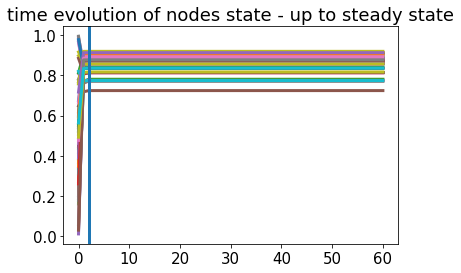

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] JACOBIAN DISTANCE - Synchronization
Integration up to steady state...


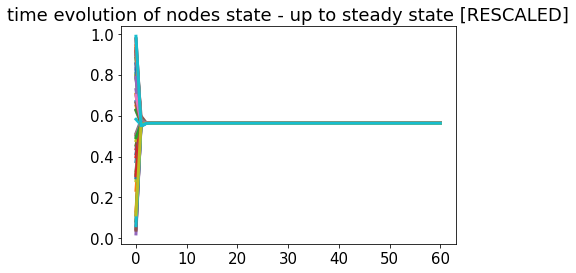

Evaluating jacobian distance...


  0%|          | 0/61 [00:00<?, ?it/s]

[*] DIFFUSION DISTANCE
Evaluating diffusion distance...


  0%|          | 0/61 [00:00<?, ?it/s]

In [18]:
res_ba = Simu(G_ba, [], dynamics_list)
res_sw = Simu(G_sw, [], dynamics_list)
res_er = Simu(G_er, [], dynamics_list)

In [19]:
# Get average distance matrices
avg_mat_ba = [cf.get_average_distance_matrix(mat, norm=False) for mat in res_ba[1]]
avg_mat_sw = [cf.get_average_distance_matrix(mat, norm=False) for mat in res_sw[1]]
avg_mat_er = [cf.get_average_distance_matrix(mat, norm=False) for mat in res_er[1]]

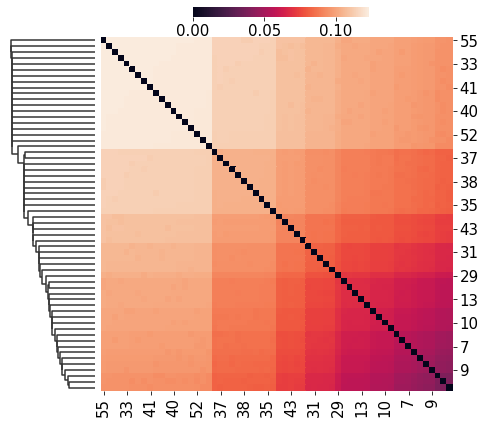

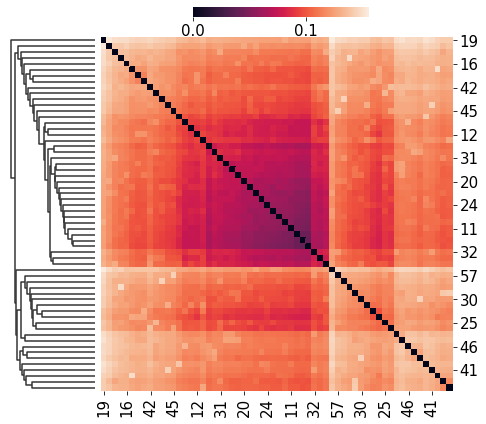

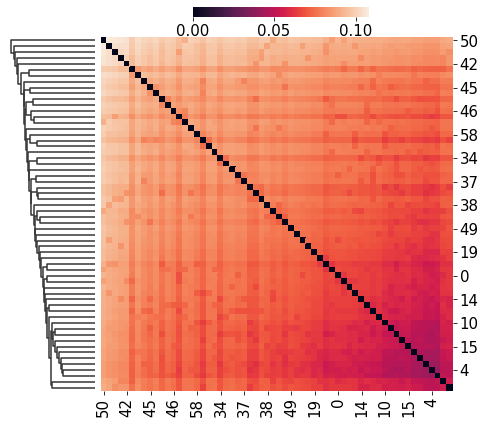

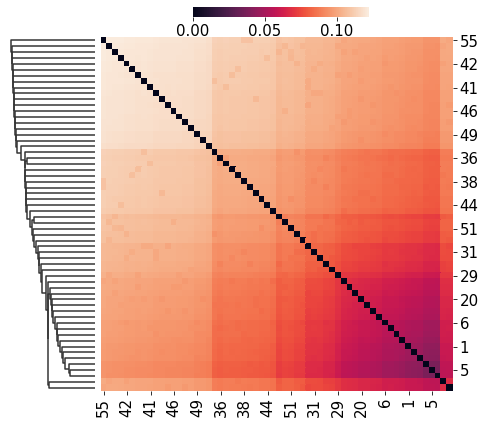

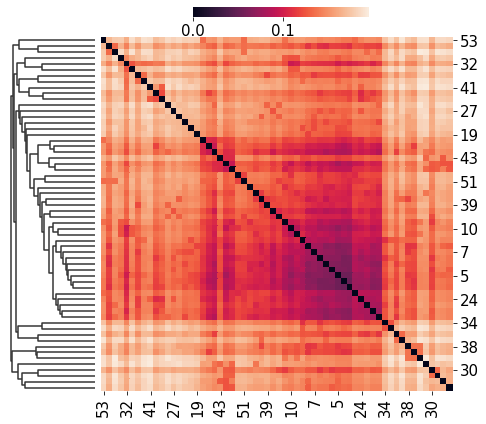

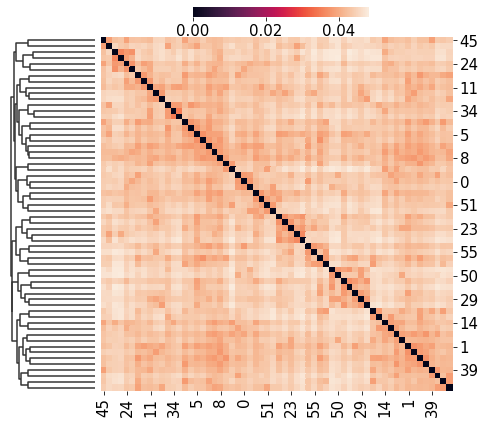

In [20]:
for i, matrix in enumerate(avg_mat_ba):
    plotter.plot_clustermap(matrix, row_colors=None, figsize=(7,7), name_to_save='BA_'+dynamics_list[i], dpi=500)

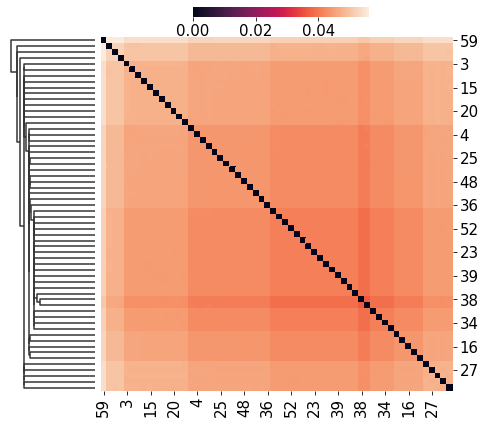

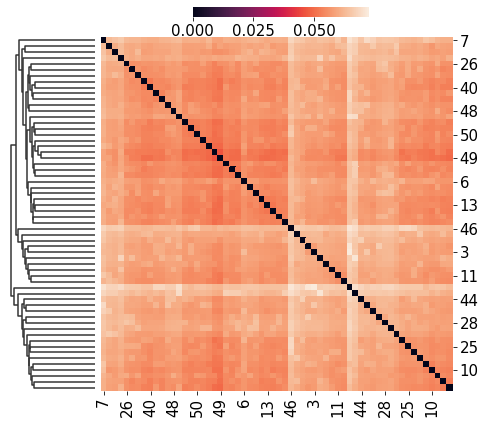

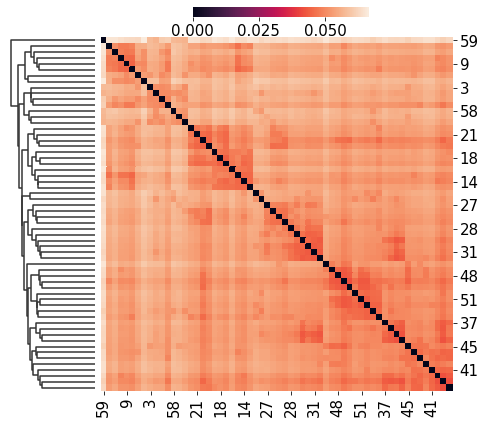

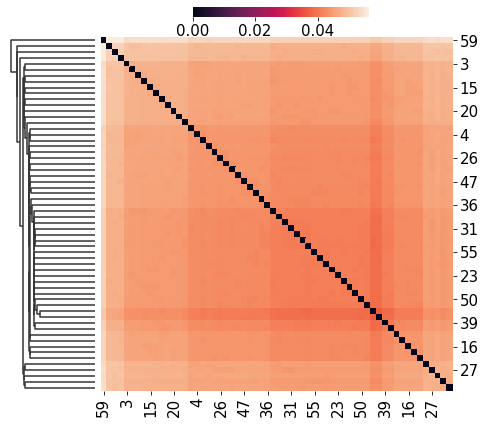

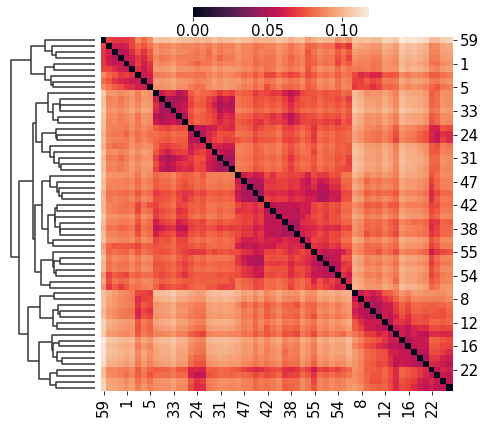

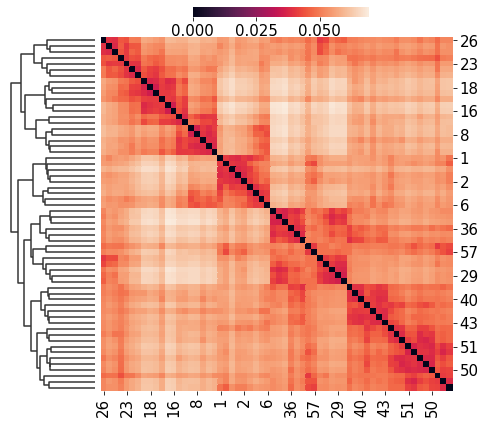

In [21]:
for i, matrix in enumerate(avg_mat_sw):
    plotter.plot_clustermap(matrix, row_colors=None, figsize=(7,7), name_to_save='SW_'+dynamics_list[i], dpi=500)

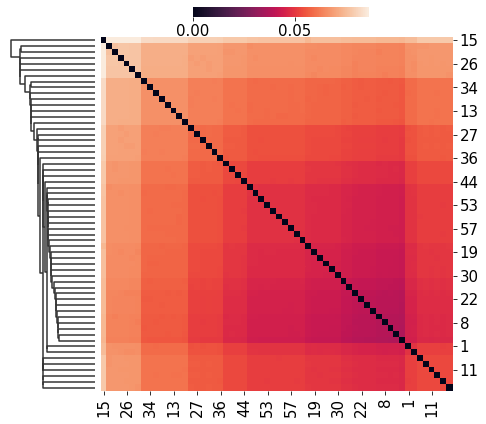

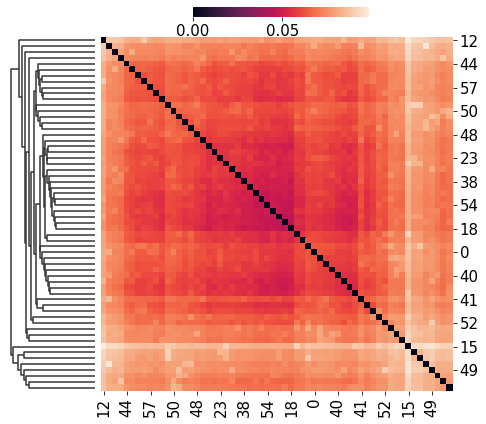

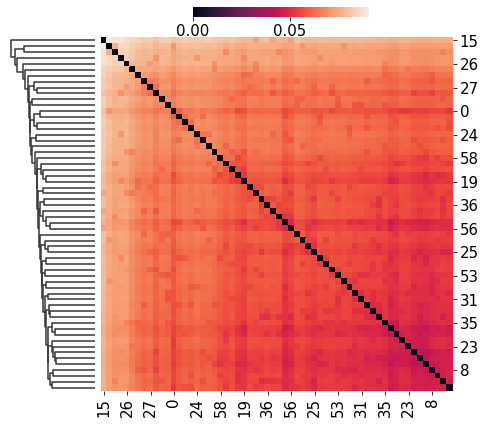

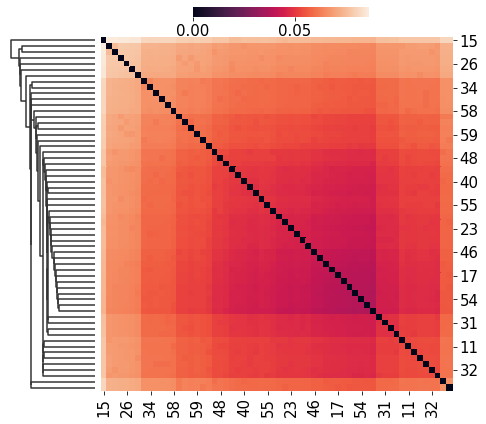

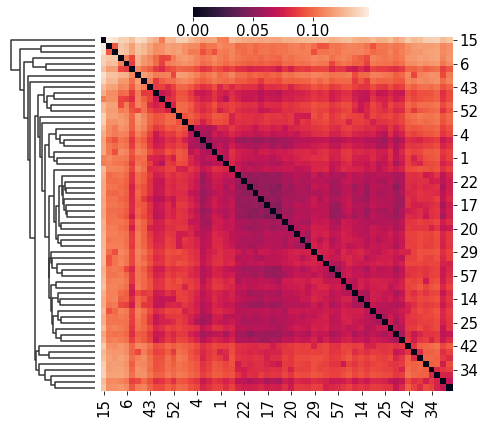

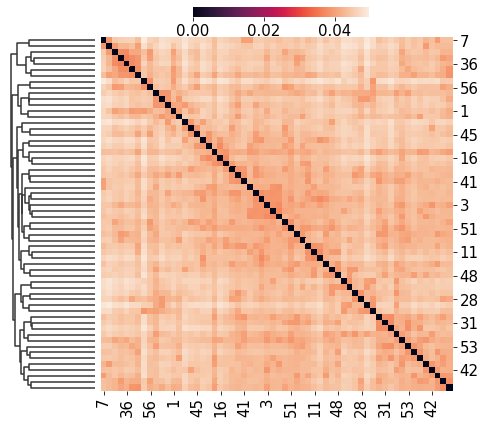

In [22]:
for i, matrix in enumerate(avg_mat_er):
    plotter.plot_clustermap(matrix, row_colors=None, figsize=(7,7), name_to_save='ER_'+dynamics_list[i], dpi=500)

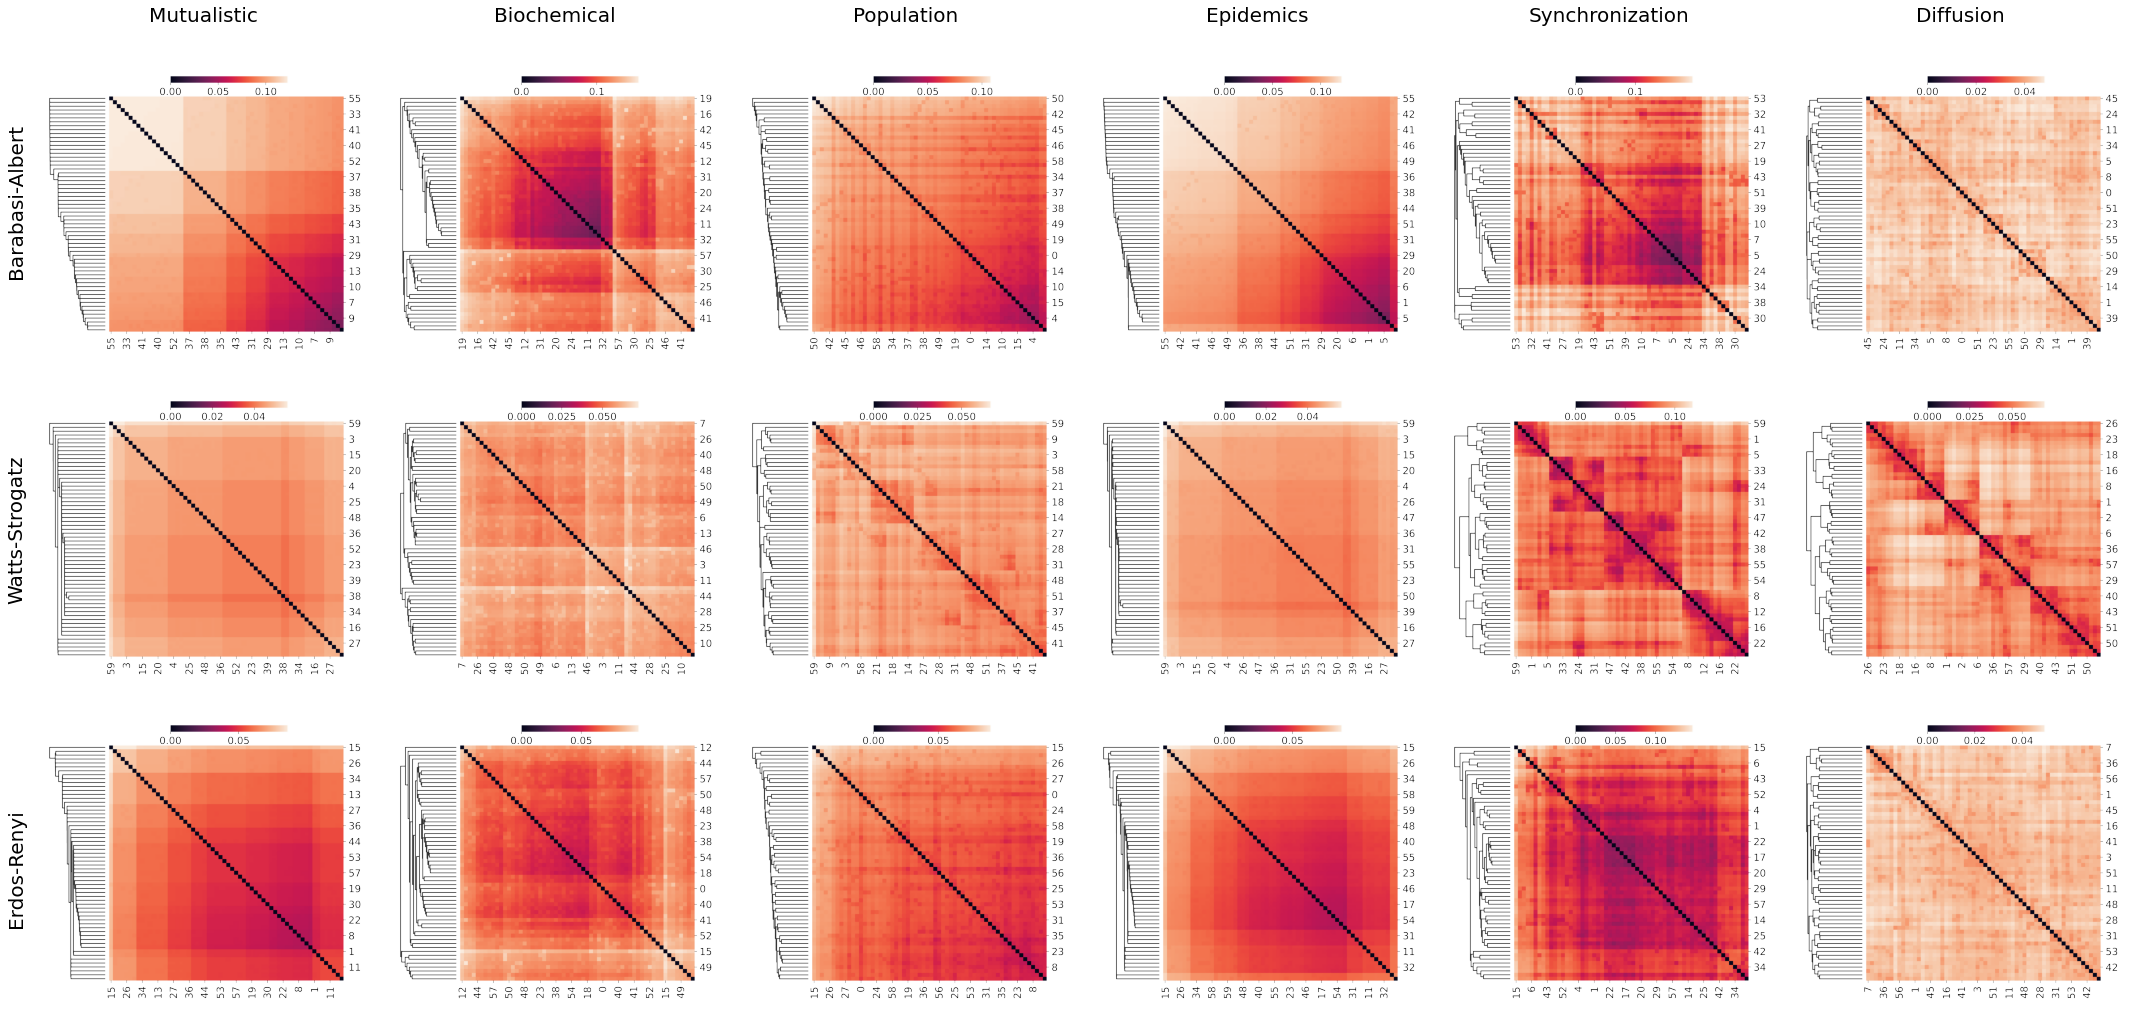

In [26]:
graphs = ['BA', 'SW', 'ER']
graph_name = ['Barabasi-Albert', 'Watts-Strogatz', 'Erdos-Renyi']

plt.figure(figsize=(30,15))

for i, dynamic in enumerate(dynamics_list):
    for j, graph in enumerate(graphs):
        plt.subplot(3,len(dynamics_list),j*len(dynamics_list)+i+1)
    
        img = mpimg.imread(graph+'_'+dynamic+'.png')
        plt.imshow(img)
        plt.axis('off')
        
        if j==0:
            plt.title(dynamics_list[i], pad=-1000, size=20)
        if i==0:
            plt.text(-300, j+1500 + 1100, graph_name[j], rotation='vertical', size=20)

plt.subplots_adjust(wspace=-0.4, hspace=-0.7)
plt.tight_layout()
plt.show()